In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks, overlapMasks02

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


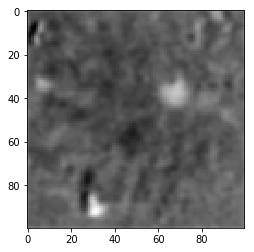

In [2]:
dataset = np.load('/home/kevinteng/Desktop/jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = 'lisa_08' #version no.
BATCH_SIZE = 8
lr01 = 0.00001 #learning rate for global 
lr02 = 0.000001 #learning rate for encoder 
lr03 = 0.1 #learning rate for learnable coords
n_neurons = 100
MAX_EPOCHS = 1000
l1_coeff = 0.1
thr = 0.3 #threshold for one hot pixel* sim score
dr = 0.4 #dropout rate
pre_pad_type = "REFLECT"
path_desktop = '/home/kevinteng/Desktop/'
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()   
    break
    

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


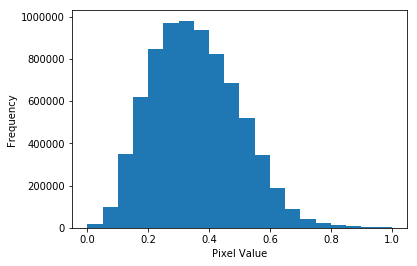

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE, min_range = 5, 
                                                            max_range = 95, Range = True)
#reshape
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[100 1 1 2]


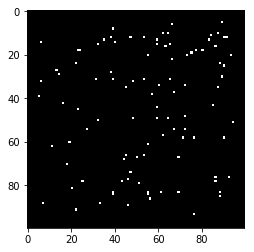

In [6]:
plt.imshow(np.squeeze(np.sum(ori_one_hot_imgs, axis=0)), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax, Dropout
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers


def encoder(inps, img_size, pre_pad_type):
    #conv block1
    paddings = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    
    coord=tf.pad(inps, paddings, pre_pad_type)
    coord1 =CoordConv(x_dim = 102, y_dim = 102, with_r = False, 
                       filters = 128,strides=(1,1), kernel_size = 3, padding='valid')(coord)
    
    act1=tf.keras.layers.ReLU()(coord1)
    pool1=MaxPooling2D((2, 2), padding='same')(act1)
    drop01 = Dropout(dr)(pool1) #dropout
    paddings2 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord3=tf.pad(drop01, paddings2, pre_pad_type)
    conv1=Conv2D(64, kernel_size = 3, padding='valid',activation = 'relu')(coord3)
    pool2=MaxPooling2D((2, 2),padding='same')(conv1)
    drop02= Dropout(dr)(pool2)
    paddings4 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    coord5=tf.pad(drop02, paddings4, pre_pad_type)
    
    x = Conv2D(128, 3, padding = 'valid', activation = 'relu',activity_regularizer=l1(0.1))(coord5)
    x = UpSampling2D(size=(2, 2),interpolation='bilinear')(x) 
    
    paddings5 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings5, pre_pad_type)
    x = Conv2D(64, 3, padding = 'valid', activation = 'relu')(x)
    x = UpSampling2D(size=(2,2),interpolation='bilinear')(x)
    paddings6 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings6, pre_pad_type)
    x = Conv2D(16, 3, padding = 'valid', activation = 'relu')(x)
    paddings7 = tf.constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    x=tf.pad(x, paddings7, pre_pad_type)
    output = Conv2D(1, 3, padding = 'valid', activation = 'sigmoid', activity_regularizer=l1(0.1))(x)
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def de_conv02(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(coord01)
    f1 = Flatten()(conv01)
    output = Softmax(axis = -1)(f1)
    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
#     squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    squeeze_coords = tf.squeeze(coords)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def duplicate_batch(inp_img, batch_size):
    '''
    This function duplicate an image with respect to its batch size
    @param inp_img: input image to be duplicated
    @param batch_size: batch size, which is the number of image to be duplicated

    return duplicated images along axis 0, (batch_size, img_size, img_size, 1)
    '''
    inp_img = tf.expand_dims(inp_img, 0)
    m2 = tf.constant([batch_size, 1, 1, 1], tf.int32)  # multiplier for tiling
    duplicate_imgs = tf.tile(inp_img, m2)
    return tf.cast(duplicate_imgs, dtype = tf.float32)

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
        #clip values so that the values doesnt runs out of the normalized pixel space 
        y = tf.clip_by_value(y, clip_value_min=0.0, clip_value_max=1.0) 
        return y

In [8]:
# def encoder02(inps, img_size):
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same',
#                        activity_regularizer=l1(l1_coeff))(inps)
#     leaky01 =tf.keras.layers.ReLU()(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", 
#                     activation = 'relu',activity_regularizer=l1(l1_coeff))(leaky01 )
#     leaky02 = tf.keras.layers.ReLU()(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', 
#                     padding='same',activity_regularizer=l1(l1_coeff))(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE, pre_pad_type))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
#optimizer 
opt_global = tf.keras.optimizers.Adam(lr01)
opt_encoded_dummy = tf.keras.optimizers.Adam(lr02)
opt_coords = tf.keras.optimizers.Adam(lr03)
#loss function 
mse = tf.losses.MeanSquaredError()
bxent = tf.keras.losses.BinaryCrossentropy()
msle = tf.keras.losses.MeanSquaredLogarithmicError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size, neuron_multi = False, one_hot_thr = False):
    with tf.GradientTape(persistent=True) as tape:
        #--RHS pipeline (Learnable Coords)--
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates (n_neurons, img_size, img_size, 1)
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        #one hot images depending on the learnable coordinates
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #one hot images depending on the dummy coordinates 
        dummy_one_hot = ori_one_hot_imgs
        #--LHS pipeline (Encoder Pipeline)--
        #output from encoder (batch_size, img_size, img_size, 1)
        encoder_output = encoder_model(inp_imgs)
        
        #--Bottle Neck--
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, updated_coords, batch_size, img_size)#(batch_size, n_neurons, 3, 1)
        #compute the mse between the neurons with the one hot images generated by the deconv
        if neuron_multi==False:
            #sum one hot images for all neurons, (n_neurons, img_size, img_size, 1) => (img_size, img_size, 1)
            one_hot_sum = tf.math.reduce_sum(one_hot_imgs, 0)
            dummy_sum = tf.math.reduce_sum(dummy_one_hot, 0)
            #duplicate summed one_hot_images and compare with encoded output 
            #(img_size, img_size, 1) => (batch_size, img_size, img_size, 1) 
            duplicated_one_hot = duplicate_batch(one_hot_sum, batch_size)
            duplicated_dummy = duplicate_batch(dummy_sum, batch_size)
            #loss between the encoded output and the one hot images 
            encoded_one_loss = msle(encoder_output, duplicated_one_hot)
            #loss between the encoded output and the dummy one hot images
            encoded_dummy = msle(encoder_output, duplicated_dummy)
        #compute the mse between the neurons with one hot images multiplied by similarity scores
        elif neuron_multi==True:
            #with thresholding 
            if one_hot_thr==True:
                #multiply similarity scores with one hot images
                #(batch_size, img_size, img_size, 1)
                similarity_multi_threshold = similarity_multi(one_hot_imgs, similarity_score, thr)
                similarity_multi_threshold_dummy = similarity_multi(dummy_one_hot, similarity_score, thr)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = msle(encoder_output, similarity_multi_threshold)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = msle(encoder_output, similarity_multi_threshold_dummy)
            #without thresholding
            elif one_hot_thr==False: 
                similarity_multi_reduced_neurons = similarity_multi(one_hot_imgs, similarity_score)
                similarity_multi_reduced_dummy = similarity_multi(dummy_one_hot, similarity_score)
                #loss between the encoded output and the one hot images 
                encoded_one_loss = msle(encoder_output, similarity_multi_reduced_neurons)
                #loss between encoded outptu and the dummy one hot images
                encoded_dummy = msle(encoder_output, similarity_multi_reduced_dummy)
                
        #--Decoder--
        #reconstruction 
        reconstruction = decoder_model(latent)  
        #--Loss--
        #the loss that backprop through the whole pipeline 
        global_loss = mse(inp_imgs, reconstruction)
        #regularizer loss
        regularizer_loss = tf.math.reduce_sum(encoder_model.losses)
        #total global loss => global_loss + regularizer loss
        total_loss = global_loss + regularizer_loss
        #append loss 
        loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
    
    #back prop through encoder + decoder + learnable_coords
    varis_global = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(global_loss, varis_global)
    opt_global.apply_gradients(zip(grad_model, varis_global))
    
    #back prop through encoder
    varis_encoded_dummy = encoder_model.trainable_variables
    grad_encoder = tape.gradient(encoded_one_loss, varis_encoded_dummy)
    opt_encoded_dummy.apply_gradients(zip(grad_encoder, varis_encoded_dummy))
    
    #back prop through the learnable coords
    grad_coords = tape.gradient(global_loss, l_coords.trainable_variables)
    opt_coords.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    grad = [grad_model, grad_encoder, grad_coords]
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     print(d)
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

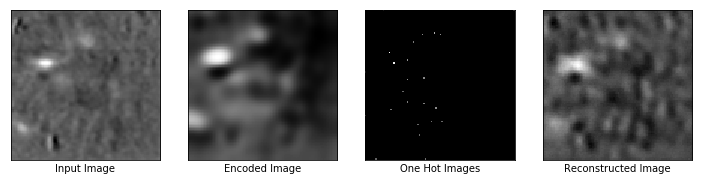

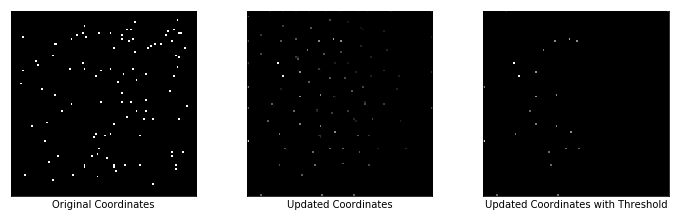

Epochs: 100, Session: 0
Reconstruction Loss: 0.0015724403783679008
Regularizer Loss: 1935.932373046875, Total Loss: 1935.9339599609375
Encoder Loss: 0.07064718008041382
Max Similarity scores: 0.7911690473556519
Updated Coordinates: [[[0.59525716 0.        ]]]
Gradient global min:-0.0006969643873162568, max:0.0004631896736100316
Gradient encoder min:-0.03835510089993477, max:0.04339345544576645
Gradient learnable coords min:-1.6928881450439803e-05, max:9.405763194081374e-06



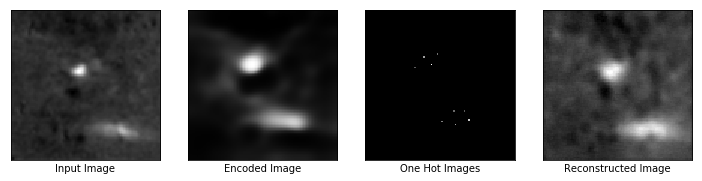

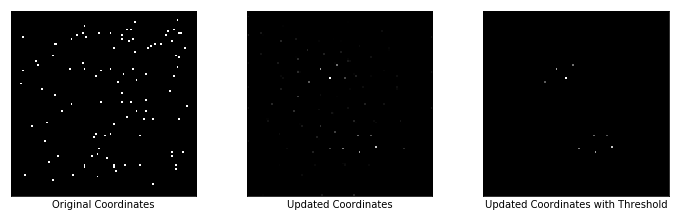

Epochs: 100, Session: 1
Reconstruction Loss: 0.0013930482091382146
Regularizer Loss: 1501.6044921875, Total Loss: 1501.6058349609375
Encoder Loss: 0.011016054078936577
Max Similarity scores: 0.9291881322860718
Updated Coordinates: [[[0.60396475 0.        ]]]
Gradient global min:-0.00015938215074129403, max:0.0007435070583596826
Gradient encoder min:-0.014287479221820831, max:0.00947711430490017
Gradient learnable coords min:-5.409011009760434e-06, max:3.2706934689485934e-06



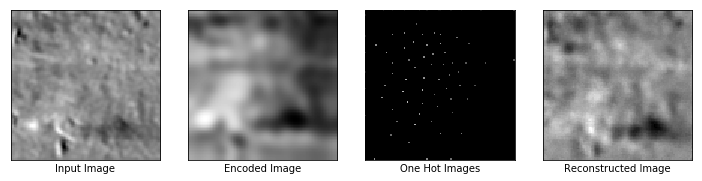

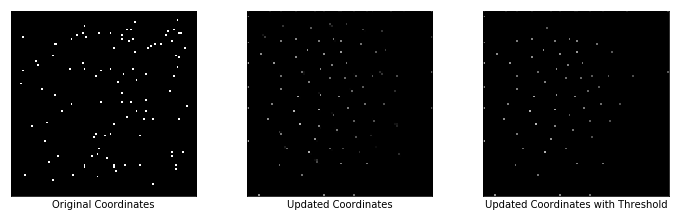

Epochs: 100, Session: 2
Reconstruction Loss: 0.002618058118969202
Regularizer Loss: 2457.269775390625, Total Loss: 2457.2724609375
Encoder Loss: 0.15288150310516357
Max Similarity scores: 0.768230140209198
Updated Coordinates: [[[0.57675654 0.        ]]]
Gradient global min:-0.0018664641538634896, max:0.0014902973780408502
Gradient encoder min:-0.06228753179311752, max:0.09708967804908752
Gradient learnable coords min:-2.7120933737023734e-05, max:2.9309398087207228e-05



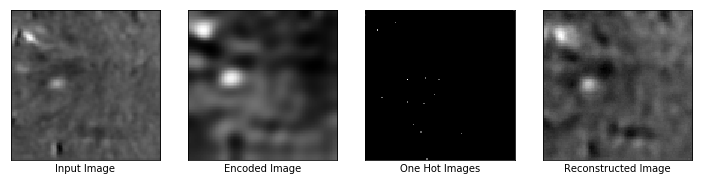

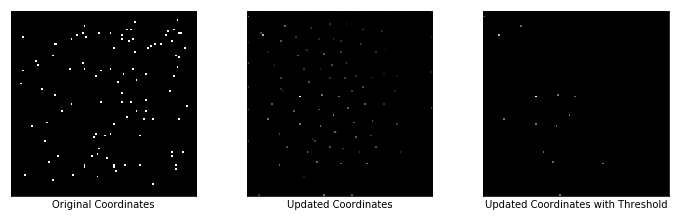

Epochs: 100, Session: 3
Reconstruction Loss: 0.0013696574606001377
Regularizer Loss: 2116.88134765625, Total Loss: 2116.8828125
Encoder Loss: 0.09806090593338013
Max Similarity scores: 0.7661908268928528
Updated Coordinates: [[[0.5742534 0.       ]]]
Gradient global min:-0.001987086609005928, max:0.002489969599992037
Gradient encoder min:-0.044988200068473816, max:0.06236319616436958
Gradient learnable coords min:-2.9756509320577607e-05, max:3.1490719266003e-05



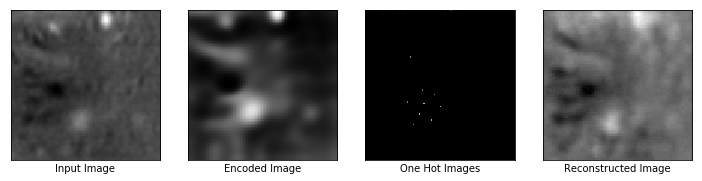

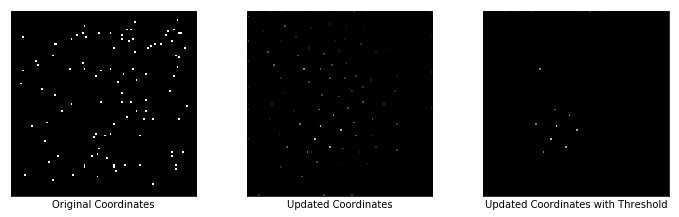

Epochs: 100, Session: 4
Reconstruction Loss: 0.001609722152352333
Regularizer Loss: 1835.79248046875, Total Loss: 1835.7940673828125
Encoder Loss: 0.05582417920231819
Max Similarity scores: 0.7209761142730713
Updated Coordinates: [[[0.5755496 0.       ]]]
Gradient global min:-0.0007122332463040948, max:0.0015612904680892825
Gradient encoder min:-0.04115525260567665, max:0.03628060966730118
Gradient learnable coords min:-8.045818503887858e-06, max:3.970753368776059e-06



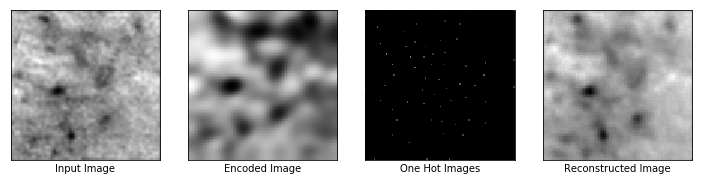

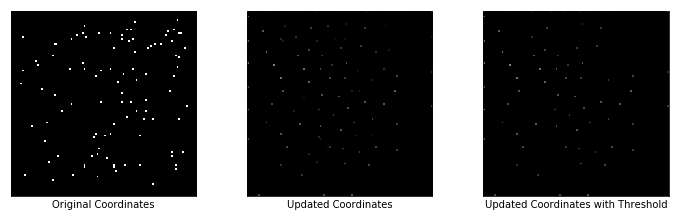

Epochs: 100, Session: 5
Reconstruction Loss: 0.002112864749506116
Regularizer Loss: 2372.422119140625, Total Loss: 2372.42431640625
Encoder Loss: 0.12905381619930267
Max Similarity scores: 0.8327349424362183
Updated Coordinates: [[[0.57435495 0.        ]]]
Gradient global min:-0.002574848709627986, max:0.0025160019285976887
Gradient encoder min:-0.05951501801609993, max:0.08404172956943512
Gradient learnable coords min:-2.327360380149912e-05, max:2.4080873117782176e-05



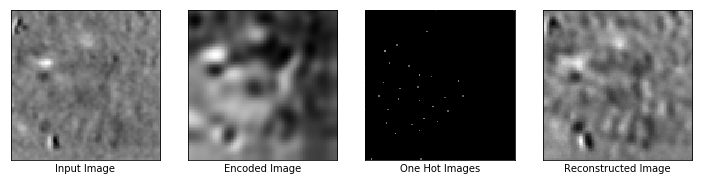

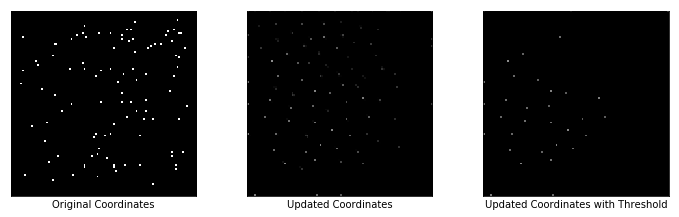

Epochs: 200, Session: 0
Reconstruction Loss: 0.0012159941252321005
Regularizer Loss: 2155.591064453125, Total Loss: 2155.59228515625
Encoder Loss: 0.04357511177659035
Max Similarity scores: 0.49208030104637146
Updated Coordinates: [[[0.56617767 0.        ]]]
Gradient global min:-0.0012525185011327267, max:0.0014519065152853727
Gradient encoder min:-0.05036546289920807, max:0.044757500290870667
Gradient learnable coords min:-1.9744233213714324e-05, max:1.628112113394309e-05



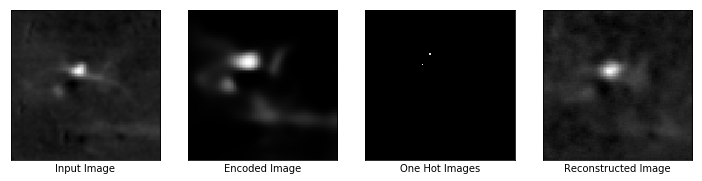

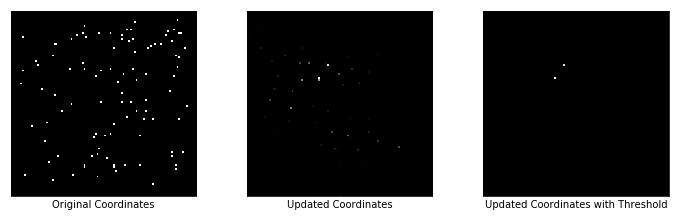

Epochs: 200, Session: 1
Reconstruction Loss: 0.0010751067893579602
Regularizer Loss: 1936.872802734375, Total Loss: 1936.8739013671875
Encoder Loss: 0.007190418429672718
Max Similarity scores: 0.6931490898132324
Updated Coordinates: [[[0.55355567 0.        ]]]
Gradient global min:-0.0003638456983026117, max:0.0004542986862361431
Gradient encoder min:-0.013907440938055515, max:0.010635120794177055
Gradient learnable coords min:-0.0002860411477740854, max:0.00043348432518541813



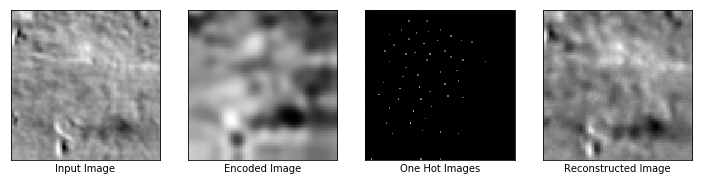

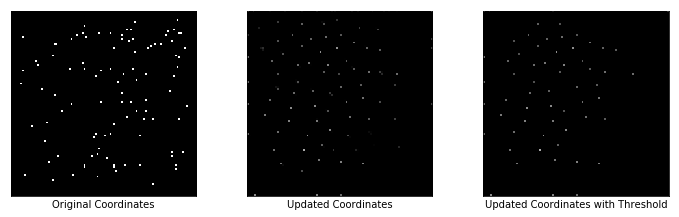

Epochs: 200, Session: 2
Reconstruction Loss: 0.0018690872238948941
Regularizer Loss: 2554.596923828125, Total Loss: 2554.598876953125
Encoder Loss: 0.09883274137973785
Max Similarity scores: 0.6606209874153137
Updated Coordinates: [[[0.5646898 0.       ]]]
Gradient global min:-0.0051347967237234116, max:0.003563947742804885
Gradient encoder min:-0.0794973149895668, max:0.10187686234712601
Gradient learnable coords min:-3.274690607213415e-05, max:1.1782840374507941e-05



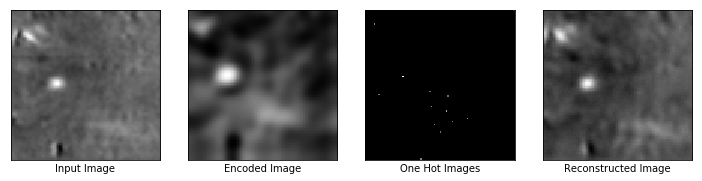

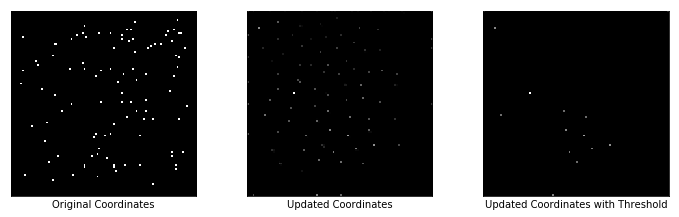

Epochs: 200, Session: 3
Reconstruction Loss: 0.001074709463864565
Regularizer Loss: 2260.53369140625, Total Loss: 2260.53466796875
Encoder Loss: 0.06346449255943298
Max Similarity scores: 0.7214131355285645
Updated Coordinates: [[[0.56340986 0.        ]]]
Gradient global min:-0.0016762418672442436, max:0.0017629257636144757
Gradient encoder min:-0.06381550431251526, max:0.06361397355794907
Gradient learnable coords min:-1.0711189133871812e-05, max:5.8068202633876354e-05



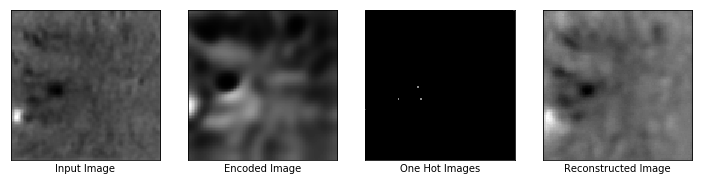

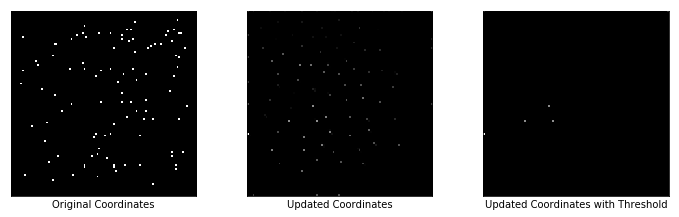

Epochs: 200, Session: 4
Reconstruction Loss: 0.0014097774401307106
Regularizer Loss: 2065.25244140625, Total Loss: 2065.25390625
Encoder Loss: 0.035191915929317474
Max Similarity scores: 0.5723771452903748
Updated Coordinates: [[[0.5637002 0.       ]]]
Gradient global min:-0.0055031925439834595, max:0.0034767338074743748
Gradient encoder min:-0.049776069819927216, max:0.037599362432956696
Gradient learnable coords min:-9.331778528576251e-06, max:1.69005634234054e-05



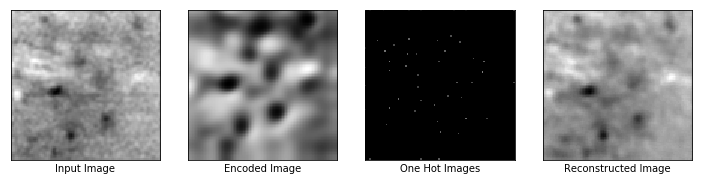

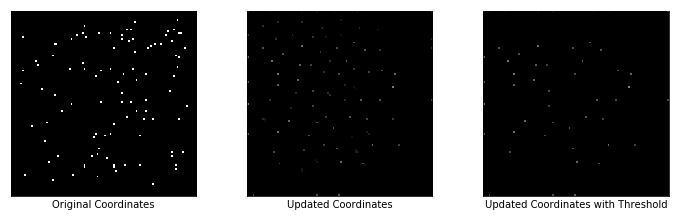

Epochs: 200, Session: 5
Reconstruction Loss: 0.0019496349850669503
Regularizer Loss: 2478.65966796875, Total Loss: 2478.66162109375
Encoder Loss: 0.08258312195539474
Max Similarity scores: 0.6178498268127441
Updated Coordinates: [[[0.5656483 0.       ]]]
Gradient global min:-0.004562037531286478, max:0.00346343033015728
Gradient encoder min:-0.07287168502807617, max:0.08239472657442093
Gradient learnable coords min:-1.6264904843410477e-05, max:2.8127884434070438e-05



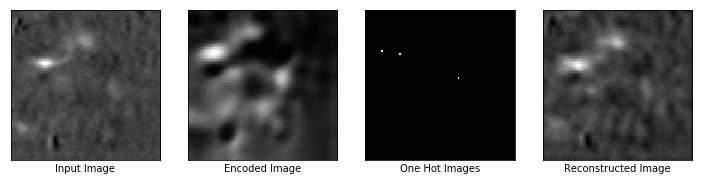

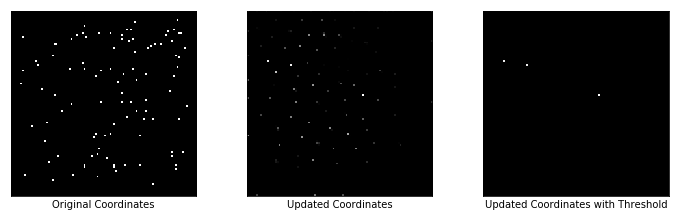

Epochs: 300, Session: 0
Reconstruction Loss: 0.001074396655894816
Regularizer Loss: 3141.41259765625, Total Loss: 3141.41357421875
Encoder Loss: 0.03221997618675232
Max Similarity scores: 0.3922414779663086
Updated Coordinates: [[[0.52330315 0.        ]]]
Gradient global min:-0.0006096886354498565, max:0.0006584031507372856
Gradient encoder min:-0.04075603559613228, max:0.03407106176018715
Gradient learnable coords min:-5.424939445219934e-06, max:1.9394616174395196e-05



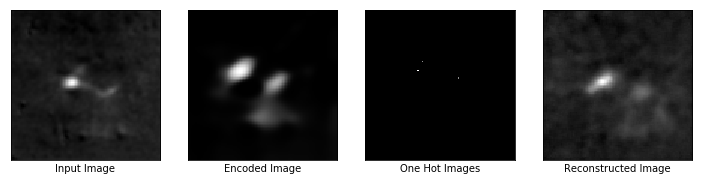

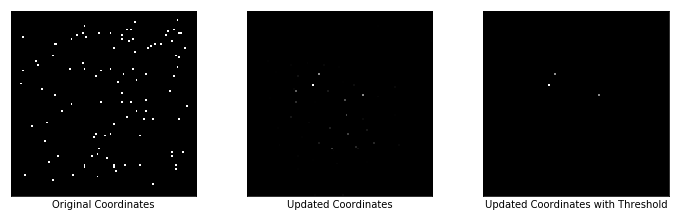

Epochs: 300, Session: 1
Reconstruction Loss: 0.0009434858220629394
Regularizer Loss: 2873.1865234375, Total Loss: 2873.1875
Encoder Loss: 0.005349178798496723
Max Similarity scores: 0.6327154636383057
Updated Coordinates: [[[0.5240774 0.       ]]]
Gradient global min:-8.019291999517009e-05, max:0.000232450503972359
Gradient encoder min:-0.01178224291652441, max:0.00955232698470354
Gradient learnable coords min:-7.702012226218358e-06, max:1.870876076282002e-05



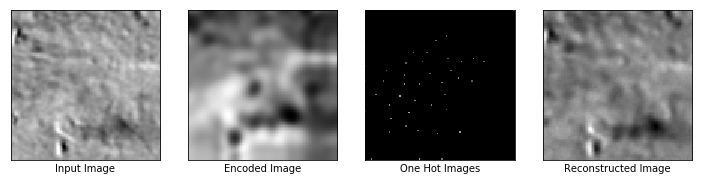

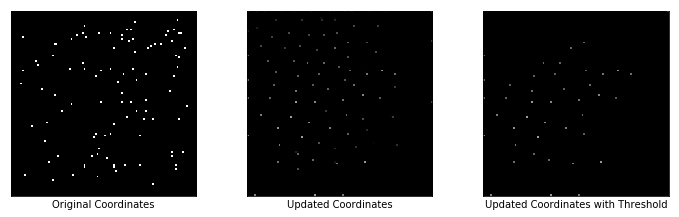

Epochs: 300, Session: 2
Reconstruction Loss: 0.00151024479418993
Regularizer Loss: 3580.185791015625, Total Loss: 3580.187255859375
Encoder Loss: 0.0708644911646843
Max Similarity scores: 0.5404455661773682
Updated Coordinates: [[[0.5234603 0.       ]]]
Gradient global min:-0.0016548048006370664, max:0.0018792124465107918
Gradient encoder min:-0.06479467451572418, max:0.07516758143901825
Gradient learnable coords min:-3.4374090773781063e-06, max:1.3389204468694516e-05



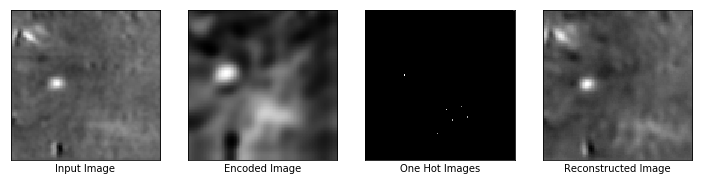

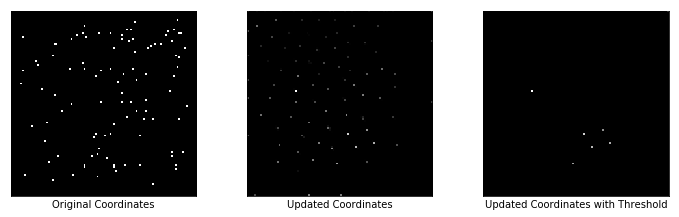

Epochs: 300, Session: 3
Reconstruction Loss: 0.0009268347639590502
Regularizer Loss: 3232.9990234375, Total Loss: 3233.0
Encoder Loss: 0.04666705057024956
Max Similarity scores: 0.5442152619361877
Updated Coordinates: [[[0.5224182 0.       ]]]
Gradient global min:-0.0016026899684220552, max:0.001961118308827281
Gradient encoder min:-0.05343327298760414, max:0.04724515601992607
Gradient learnable coords min:-2.19719313463429e-05, max:1.3096226211928297e-05



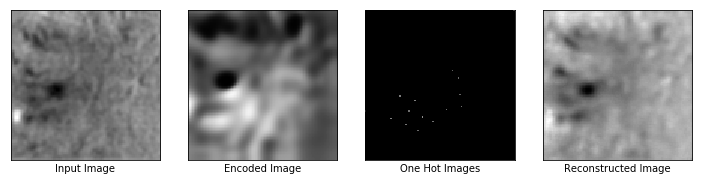

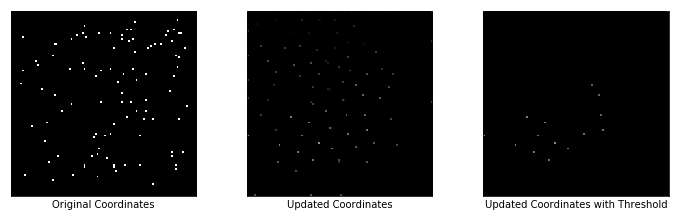

Epochs: 300, Session: 4
Reconstruction Loss: 0.0015095201088115573
Regularizer Loss: 3035.724609375, Total Loss: 3035.72607421875
Encoder Loss: 0.026777291670441628
Max Similarity scores: 0.4571927487850189
Updated Coordinates: [[[0.5244814 0.       ]]]
Gradient global min:-0.0052604032680392265, max:0.00342204375192523
Gradient encoder min:-0.03818716108798981, max:0.030064070597290993
Gradient learnable coords min:-4.412196722114459e-05, max:0.00015106837963685393



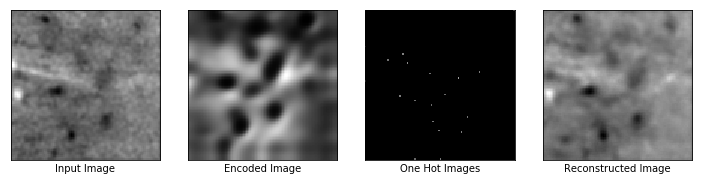

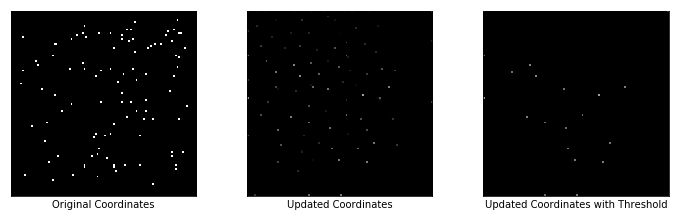

Epochs: 300, Session: 5
Reconstruction Loss: 0.0018855115631595254
Regularizer Loss: 3498.125244140625, Total Loss: 3498.127197265625
Encoder Loss: 0.060838211327791214
Max Similarity scores: 0.47480517625808716
Updated Coordinates: [[[0.52302325 0.        ]]]
Gradient global min:-0.007731896359473467, max:0.0070363422855734825
Gradient encoder min:-0.060668084770441055, max:0.061792753636837006
Gradient learnable coords min:-3.85429484595079e-05, max:1.2174128642072901e-05



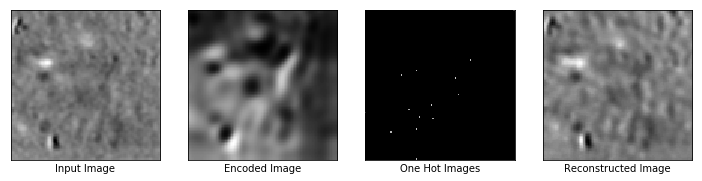

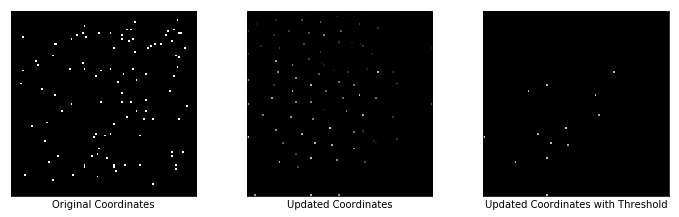

Epochs: 400, Session: 0
Reconstruction Loss: 0.0010887962998822331
Regularizer Loss: 5197.23583984375, Total Loss: 5197.23681640625
Encoder Loss: 0.024542048573493958
Max Similarity scores: 0.37886980175971985
Updated Coordinates: [[[0.50021803 0.        ]]]
Gradient global min:-0.0029262679163366556, max:0.003938704263418913
Gradient encoder min:-0.0213911272585392, max:0.019960695877671242
Gradient learnable coords min:-6.249971920624375e-05, max:2.6560395781416446e-05



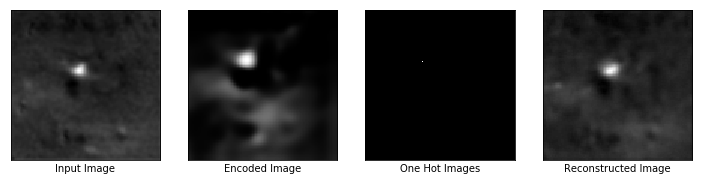

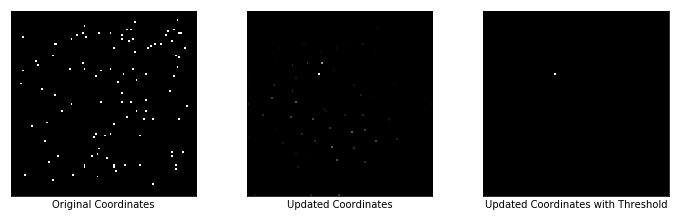

Epochs: 400, Session: 1
Reconstruction Loss: 0.000858389656059444
Regularizer Loss: 4765.958984375, Total Loss: 4765.9599609375
Encoder Loss: 0.003902304684743285
Max Similarity scores: 0.49554353952407837
Updated Coordinates: [[[0.5020392 0.       ]]]
Gradient global min:-0.00048626598436385393, max:0.0004680404672399163
Gradient encoder min:-0.0072321961633861065, max:0.005459096748381853
Gradient learnable coords min:-2.0629571736208163e-05, max:3.071234095841646e-05



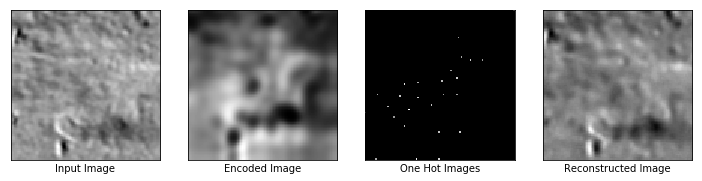

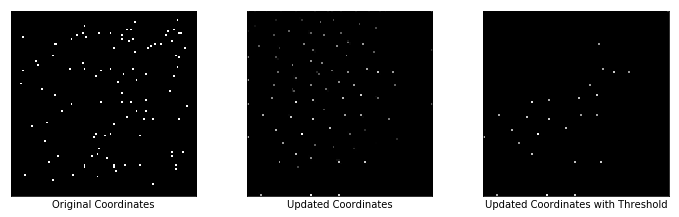

Epochs: 400, Session: 2
Reconstruction Loss: 0.001376884407363832
Regularizer Loss: 5777.416015625, Total Loss: 5777.41748046875
Encoder Loss: 0.05521906912326813
Max Similarity scores: 0.504916787147522
Updated Coordinates: [[[0.50233936 0.        ]]]
Gradient global min:-0.0031505830120295286, max:0.0024952914100140333
Gradient encoder min:-0.03970390930771828, max:0.05376671999692917
Gradient learnable coords min:-1.5838942999835126e-05, max:1.5190010344667826e-05



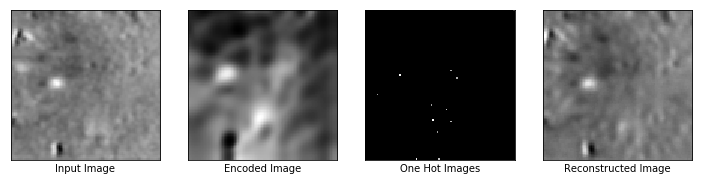

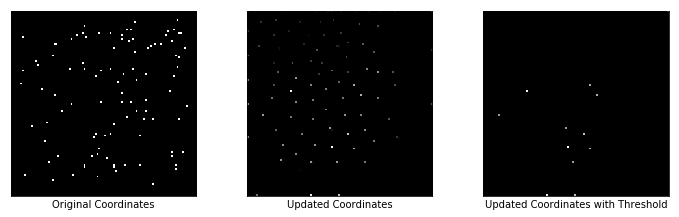

Epochs: 400, Session: 3
Reconstruction Loss: 0.0008134437375701964
Regularizer Loss: 5303.7392578125, Total Loss: 5303.740234375
Encoder Loss: 0.03512555733323097
Max Similarity scores: 0.5148342251777649
Updated Coordinates: [[[0.50277567 0.        ]]]
Gradient global min:-0.0009060610318556428, max:0.0010416579898446798
Gradient encoder min:-0.03171699866652489, max:0.029183004051446915
Gradient learnable coords min:-9.855186362983659e-06, max:5.502225121745141e-06



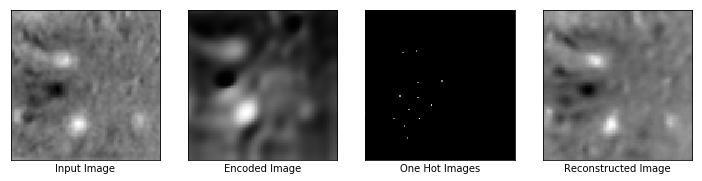

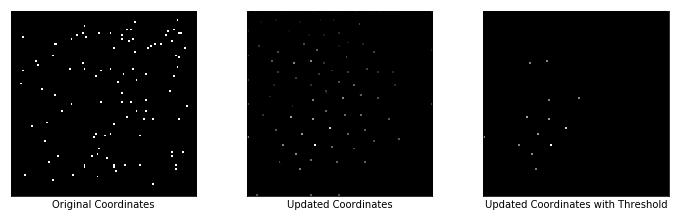

Epochs: 400, Session: 4
Reconstruction Loss: 0.0013033495051786304
Regularizer Loss: 5050.6923828125, Total Loss: 5050.69384765625
Encoder Loss: 0.019526047632098198
Max Similarity scores: 0.6330653429031372
Updated Coordinates: [[[0.5043491 0.       ]]]
Gradient global min:-0.0035116616636514664, max:0.006258048117160797
Gradient encoder min:-0.025631090626120567, max:0.01800885982811451
Gradient learnable coords min:-5.550570131163113e-05, max:1.0607908734527882e-05



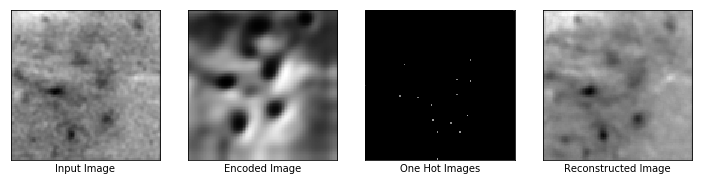

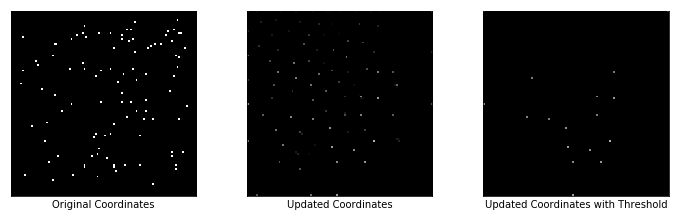

Epochs: 400, Session: 5
Reconstruction Loss: 0.0017492648912593722
Regularizer Loss: 5657.42138671875, Total Loss: 5657.42333984375
Encoder Loss: 0.046740274876356125
Max Similarity scores: 0.4423418641090393
Updated Coordinates: [[[0.503837 0.      ]]]
Gradient global min:-0.0018891756189987063, max:0.0025876984000205994
Gradient encoder min:-0.037830960005521774, max:0.040992144495248795
Gradient learnable coords min:-1.1057734809583053e-05, max:1.8452548829372972e-05



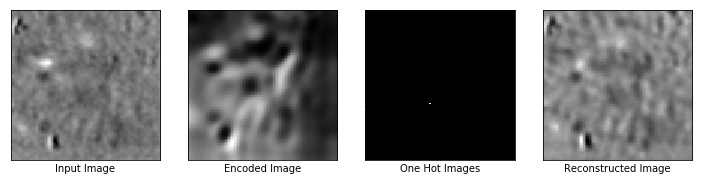

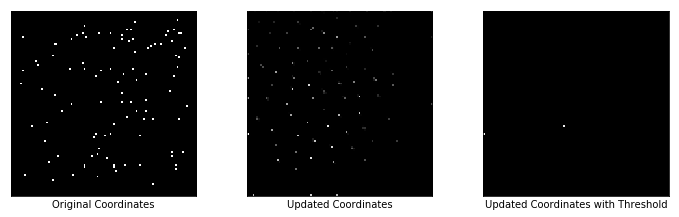

Epochs: 500, Session: 0
Reconstruction Loss: 0.0011899856617674232
Regularizer Loss: 7348.9384765625, Total Loss: 7348.939453125
Encoder Loss: 0.01777414232492447
Max Similarity scores: 0.34023725986480713
Updated Coordinates: [[[0.46186477 0.        ]]]
Gradient global min:-0.0009277385543100536, max:0.0006641764775849879
Gradient encoder min:-0.02284151501953602, max:0.012499991804361343
Gradient learnable coords min:-0.0003575476002879441, max:0.00013799563748762012



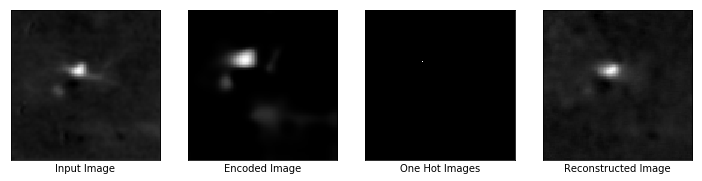

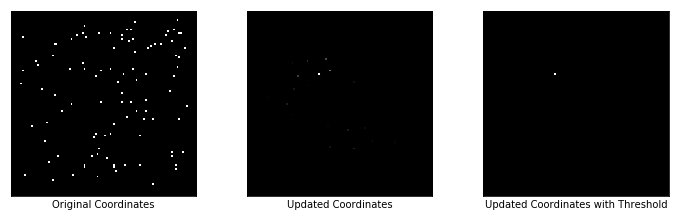

Epochs: 500, Session: 1
Reconstruction Loss: 0.0008109573391266167
Regularizer Loss: 6920.69580078125, Total Loss: 6920.69677734375
Encoder Loss: 0.003055586013942957
Max Similarity scores: 0.49373120069503784
Updated Coordinates: [[[0.45118043 0.        ]]]
Gradient global min:-0.0004612939083017409, max:0.0005409012082964182
Gradient encoder min:-0.0057504428550601006, max:0.003078281646594405
Gradient learnable coords min:-4.466730388230644e-05, max:3.397996988496743e-05



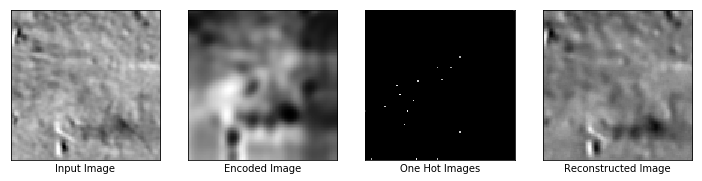

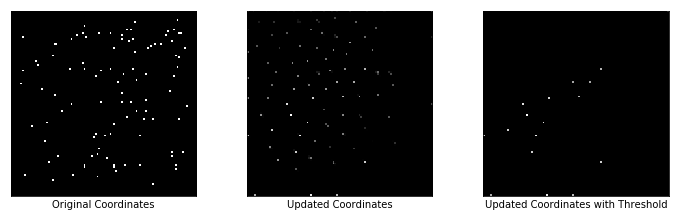

Epochs: 500, Session: 2
Reconstruction Loss: 0.0012705335393548012
Regularizer Loss: 7999.609375, Total Loss: 7999.61083984375
Encoder Loss: 0.04183439910411835
Max Similarity scores: 0.46519026160240173
Updated Coordinates: [[[0.45206305 0.        ]]]
Gradient global min:-0.005810894072055817, max:0.007752212230116129
Gradient encoder min:-0.049179960042238235, max:0.03219883143901825
Gradient learnable coords min:-2.522875729482621e-05, max:3.853942689602263e-05



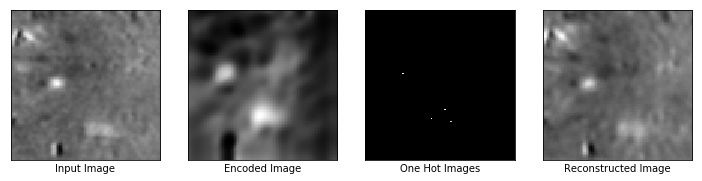

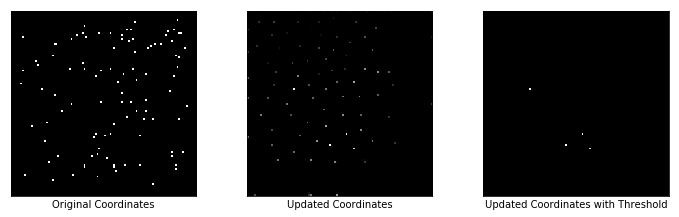

Epochs: 500, Session: 3
Reconstruction Loss: 0.0007950292783789337
Regularizer Loss: 7428.923828125, Total Loss: 7428.9248046875
Encoder Loss: 0.026077790185809135
Max Similarity scores: 0.44938716292381287
Updated Coordinates: [[[0.452163 0.      ]]]
Gradient global min:-0.0023503967095166445, max:0.0027038981206715107
Gradient encoder min:-0.03396478295326233, max:0.016330284997820854
Gradient learnable coords min:-1.2747497748932801e-05, max:1.3423126802081242e-05



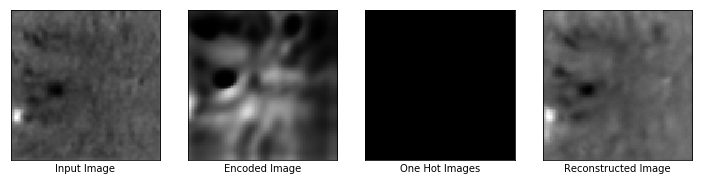

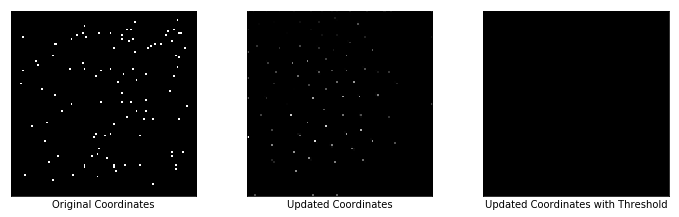

Epochs: 500, Session: 4
Reconstruction Loss: 0.001217408454976976
Regularizer Loss: 7175.2138671875, Total Loss: 7175.21484375
Encoder Loss: 0.015169329941272736
Max Similarity scores: 0.26705923676490784
Updated Coordinates: [[[0.4541621 0.       ]]]
Gradient global min:-0.04932825639843941, max:0.02864157222211361
Gradient encoder min:-0.022380484268069267, max:0.011251048184931278
Gradient learnable coords min:-1.762586362019647e-05, max:9.78034131549066e-06



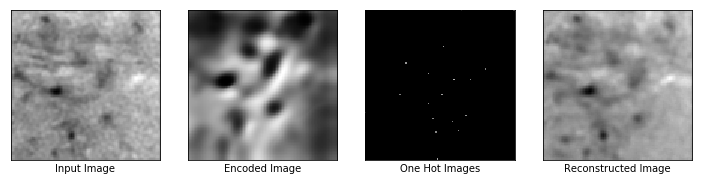

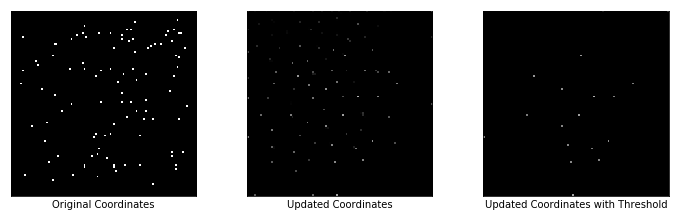

Epochs: 500, Session: 5
Reconstruction Loss: 0.001711957505904138
Regularizer Loss: 7860.72265625, Total Loss: 7860.724609375
Encoder Loss: 0.03498521074652672
Max Similarity scores: 0.44725552201271057
Updated Coordinates: [[[0.45405787 0.        ]]]
Gradient global min:-0.0024639025796204805, max:0.004102271981537342
Gradient encoder min:-0.042919911444187164, max:0.024830903857946396
Gradient learnable coords min:-5.367035555536859e-05, max:3.377703615115024e-05



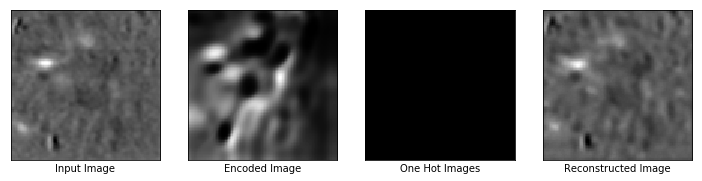

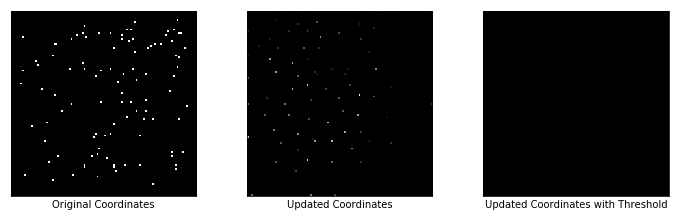

Epochs: 600, Session: 0
Reconstruction Loss: 0.0008535716915503144
Regularizer Loss: 9212.85546875, Total Loss: 9212.8564453125
Encoder Loss: 0.012507056817412376
Max Similarity scores: 0.28622251749038696
Updated Coordinates: [[[0.4819215 0.       ]]]
Gradient global min:-0.0030054047238081694, max:0.0015829873736947775
Gradient encoder min:-0.013369525782763958, max:0.009461401961743832
Gradient learnable coords min:-1.2831879757868592e-05, max:2.9798387913615443e-05



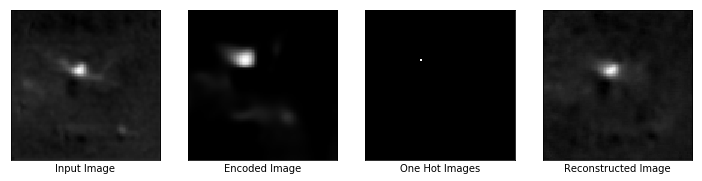

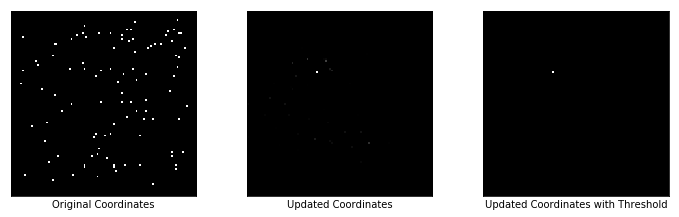

Epochs: 600, Session: 1
Reconstruction Loss: 0.0008285026415251195
Regularizer Loss: 9009.927734375, Total Loss: 9009.9287109375
Encoder Loss: 0.0018958852160722017
Max Similarity scores: 0.4056130349636078
Updated Coordinates: [[[0.48203358 0.        ]]]
Gradient global min:-0.0012026180047541857, max:0.0013500761706382036
Gradient encoder min:-0.0026956317014992237, max:0.0015031257644295692
Gradient learnable coords min:-3.247351196478121e-05, max:1.850466287578456e-05



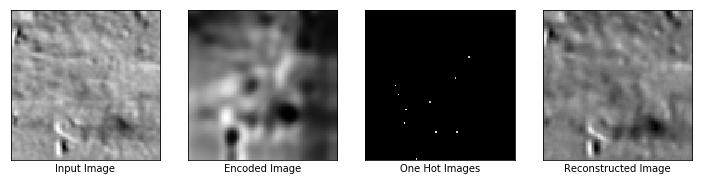

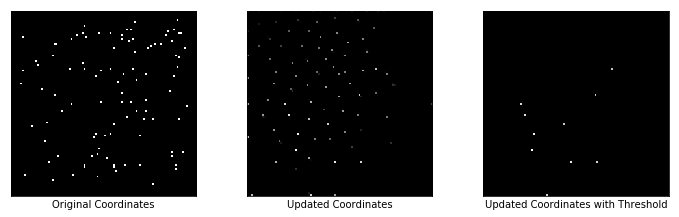

Epochs: 600, Session: 2
Reconstruction Loss: 0.0011897401418536901
Regularizer Loss: 9752.3876953125, Total Loss: 9752.388671875
Encoder Loss: 0.032373376190662384
Max Similarity scores: 0.41180309653282166
Updated Coordinates: [[[0.48216158 0.        ]]]
Gradient global min:-0.0010707207256928086, max:0.001242486061528325
Gradient encoder min:-0.02756262570619583, max:0.02041412517428398
Gradient learnable coords min:-6.769973879272584e-06, max:2.5373739845235832e-05



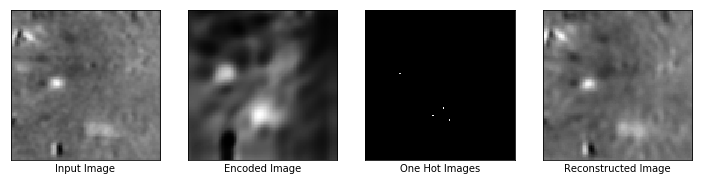

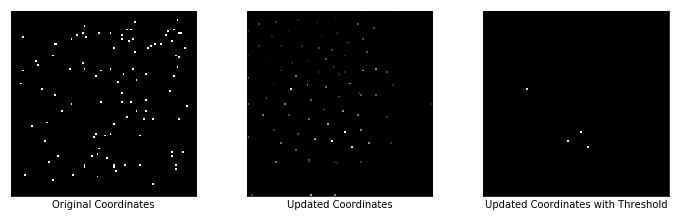

Epochs: 600, Session: 3
Reconstruction Loss: 0.0007289318018592894
Regularizer Loss: 9208.5107421875, Total Loss: 9208.51171875
Encoder Loss: 0.019328877329826355
Max Similarity scores: 0.44315606355667114
Updated Coordinates: [[[0.48278165 0.        ]]]
Gradient global min:-0.0016469284892082214, max:0.0025356467813253403
Gradient encoder min:-0.01773116923868656, max:0.013041608966886997
Gradient learnable coords min:-1.032145428325748e-05, max:5.819150828756392e-06



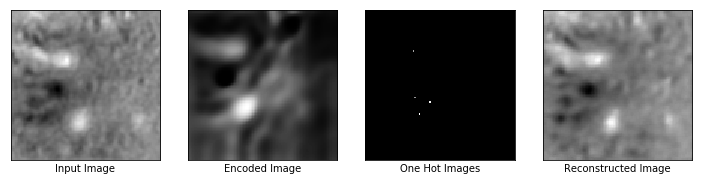

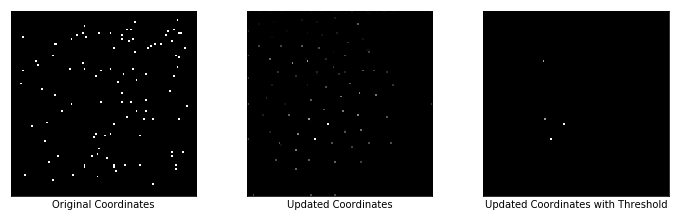

Epochs: 600, Session: 4
Reconstruction Loss: 0.0009900741279125214
Regularizer Loss: 9038.990234375, Total Loss: 9038.9912109375
Encoder Loss: 0.010365745052695274
Max Similarity scores: 0.5200059413909912
Updated Coordinates: [[[0.4855359 0.       ]]]
Gradient global min:-0.001868050661869347, max:0.0022665937431156635
Gradient encoder min:-0.011780614033341408, max:0.008353879675269127
Gradient learnable coords min:-1.503761359344935e-05, max:2.9457789423759095e-05



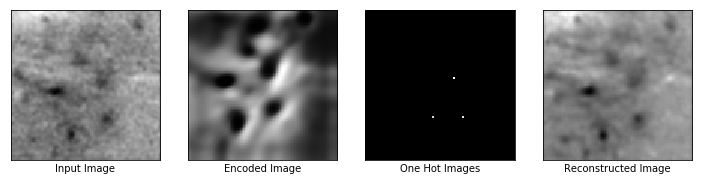

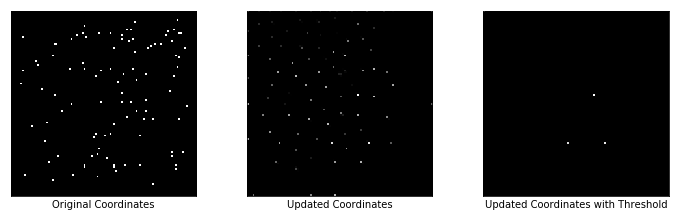

Epochs: 600, Session: 5
Reconstruction Loss: 0.001837274176068604
Regularizer Loss: 9590.994140625, Total Loss: 9590.99609375
Encoder Loss: 0.027340665459632874
Max Similarity scores: 0.36740899085998535
Updated Coordinates: [[[0.48482066 0.        ]]]
Gradient global min:-0.018222196027636528, max:0.027158372104167938
Gradient encoder min:-0.020042913034558296, max:0.01583285816013813
Gradient learnable coords min:-5.566497566178441e-05, max:2.5975003154599108e-05



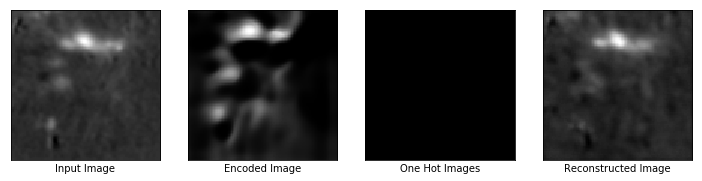

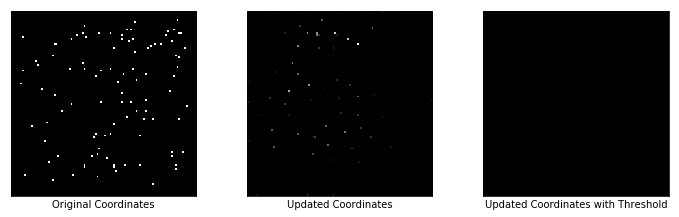

Epochs: 700, Session: 0
Reconstruction Loss: 0.0009218311170116067
Regularizer Loss: 14036.0322265625, Total Loss: 14036.033203125
Encoder Loss: 0.016297761350870132
Max Similarity scores: 0.29454144835472107
Updated Coordinates: [[[0.48100322 0.        ]]]
Gradient global min:-0.0010985656408593059, max:0.0015309762675315142
Gradient encoder min:-0.013132607564330101, max:0.012575744651257992
Gradient learnable coords min:-5.857749783899635e-05, max:1.271817473025294e-05



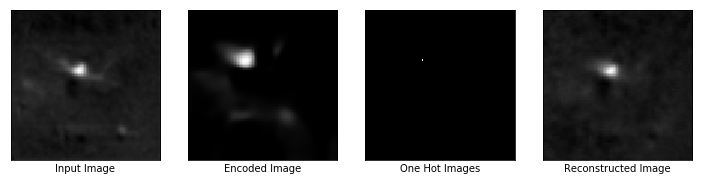

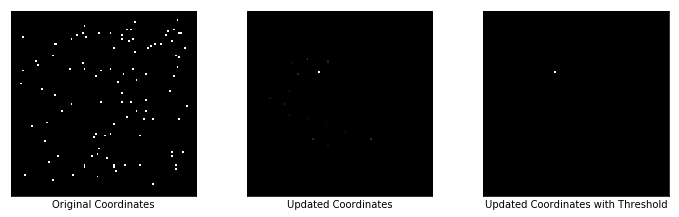

Epochs: 700, Session: 1
Reconstruction Loss: 0.0006858700071461499
Regularizer Loss: 13826.7431640625, Total Loss: 13826.744140625
Encoder Loss: 0.002331291325390339
Max Similarity scores: 0.43285617232322693
Updated Coordinates: [[[0.48278314 0.        ]]]
Gradient global min:-0.0007622316479682922, max:0.0009438659762963653
Gradient encoder min:-0.002846385585144162, max:0.0021073794923722744
Gradient learnable coords min:-1.554550362925511e-05, max:1.2008751582470722e-05



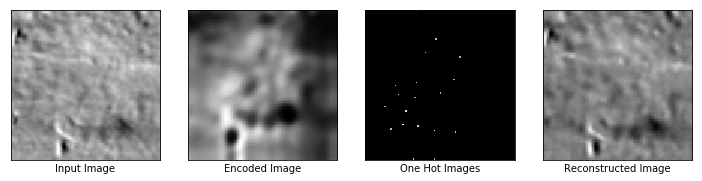

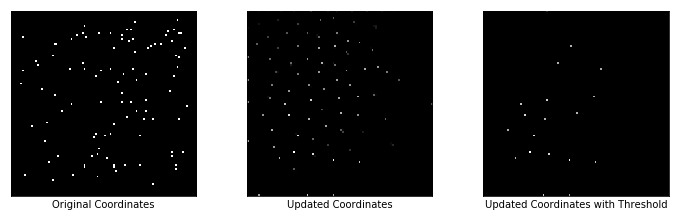

Epochs: 700, Session: 2
Reconstruction Loss: 0.00115085334982723
Regularizer Loss: 14671.5732421875, Total Loss: 14671.57421875
Encoder Loss: 0.04071641340851784
Max Similarity scores: 0.4641439914703369
Updated Coordinates: [[[0.48067063 0.        ]]]
Gradient global min:-0.08793910592794418, max:0.057692382484674454
Gradient encoder min:-0.019735142588615417, max:0.023778030648827553
Gradient learnable coords min:-2.3188198611023836e-05, max:2.776909423118923e-05



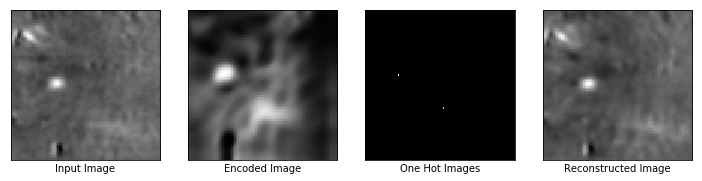

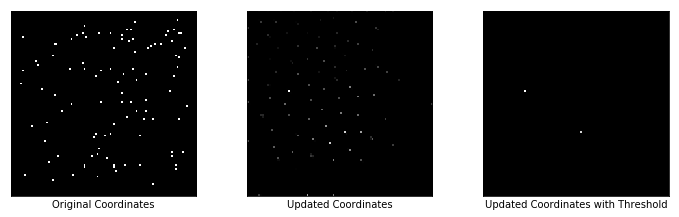

Epochs: 700, Session: 3
Reconstruction Loss: 0.0006773127824999392
Regularizer Loss: 13950.7216796875, Total Loss: 13950.72265625
Encoder Loss: 0.023026756942272186
Max Similarity scores: 0.37653377652168274
Updated Coordinates: [[[0.4856283 0.       ]]]
Gradient global min:-0.0007284838357008994, max:0.0007553299656137824
Gradient encoder min:-0.016391534358263016, max:0.015932386741042137
Gradient learnable coords min:-8.730896661290899e-05, max:2.21623031393392e-05



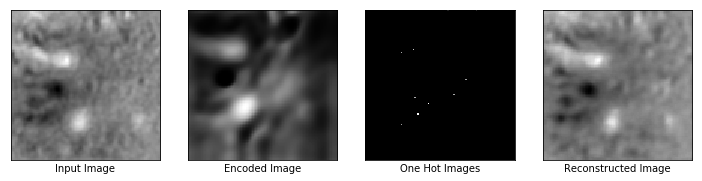

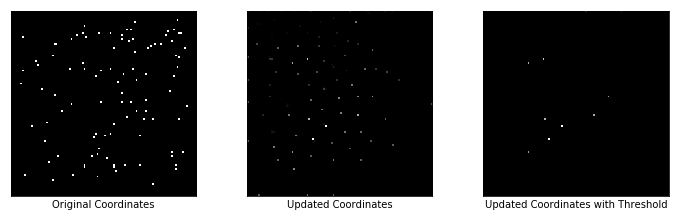

Epochs: 700, Session: 4
Reconstruction Loss: 0.001124621368944645
Regularizer Loss: 13775.884765625, Total Loss: 13775.8857421875
Encoder Loss: 0.013477631844580173
Max Similarity scores: 0.5546967387199402
Updated Coordinates: [[[0.48604926 0.        ]]]
Gradient global min:-0.004163253121078014, max:0.004512791987508535
Gradient encoder min:-0.01351393386721611, max:0.011882595717906952
Gradient learnable coords min:-1.4150273273116909e-05, max:2.733529072429519e-05



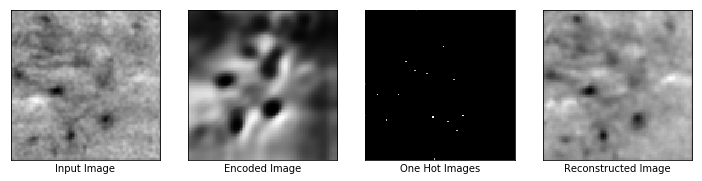

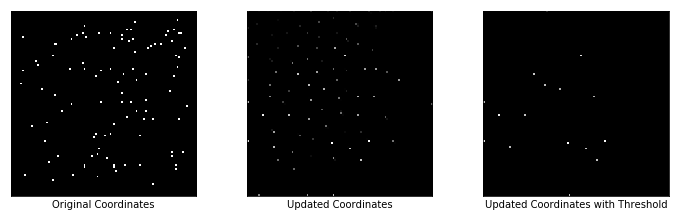

Epochs: 700, Session: 5
Reconstruction Loss: 0.0016149411676451564
Regularizer Loss: 14408.52734375, Total Loss: 14408.529296875
Encoder Loss: 0.03037334606051445
Max Similarity scores: 0.44273972511291504
Updated Coordinates: [[[0.48412955 0.        ]]]
Gradient global min:-0.000361739395884797, max:0.00024775101337581873
Gradient encoder min:-0.015505344606935978, max:0.018407538533210754
Gradient learnable coords min:-6.548746569023933e-06, max:2.202724681410473e-05



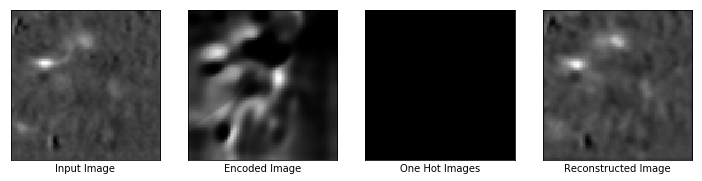

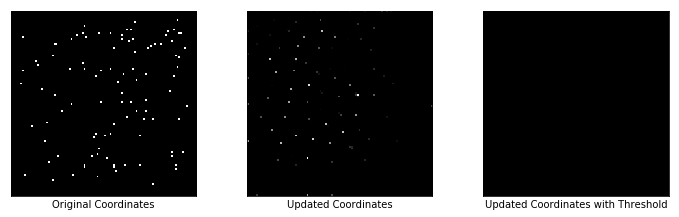

Epochs: 800, Session: 0
Reconstruction Loss: 0.0008775186724960804
Regularizer Loss: 18697.96484375, Total Loss: 18697.96484375
Encoder Loss: 0.014987890608608723
Max Similarity scores: 0.26903384923934937
Updated Coordinates: [[[0.49181923 0.        ]]]
Gradient global min:-0.0010415961733087897, max:0.0009565789951011539
Gradient encoder min:-0.012883518822491169, max:0.009448988363146782
Gradient learnable coords min:-1.1774778613471426e-05, max:1.565499223943334e-05



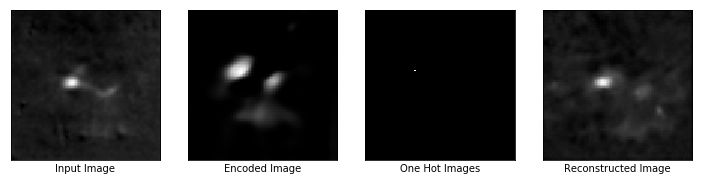

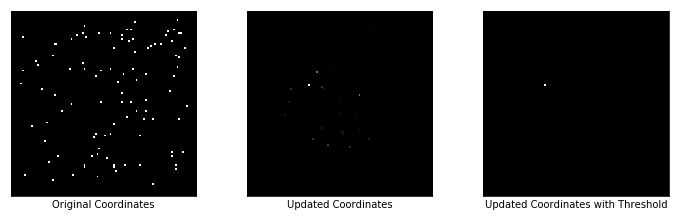

Epochs: 800, Session: 1
Reconstruction Loss: 0.000722876051440835
Regularizer Loss: 18526.8671875, Total Loss: 18526.8671875
Encoder Loss: 0.0022368140053004026
Max Similarity scores: 0.43204426765441895
Updated Coordinates: [[[0.4926542 0.       ]]]
Gradient global min:-0.00036470984923653305, max:0.00020665866031777114
Gradient encoder min:-0.0035131194163113832, max:0.0018857407849282026
Gradient learnable coords min:-1.571170287206769e-05, max:7.758436368021648e-06



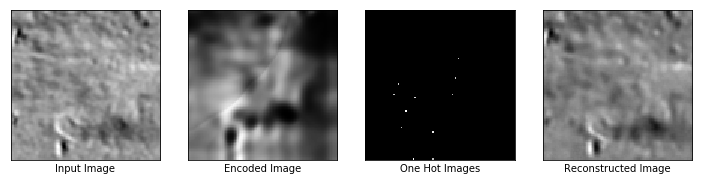

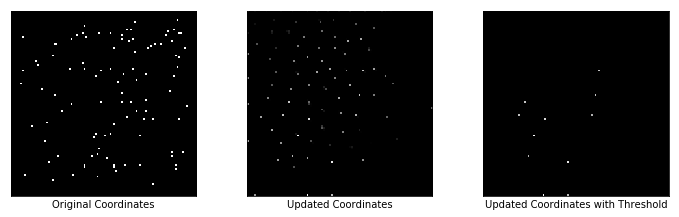

Epochs: 800, Session: 2
Reconstruction Loss: 0.0010678233811631799
Regularizer Loss: 19446.251953125, Total Loss: 19446.25390625
Encoder Loss: 0.039026983082294464
Max Similarity scores: 0.4834390878677368
Updated Coordinates: [[[0.49264753 0.        ]]]
Gradient global min:-0.0007162291440181434, max:0.000721663935109973
Gradient encoder min:-0.021902475506067276, max:0.022778959944844246
Gradient learnable coords min:-2.7971003873972222e-05, max:1.7478141671745107e-05



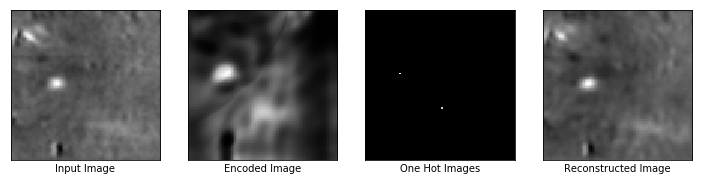

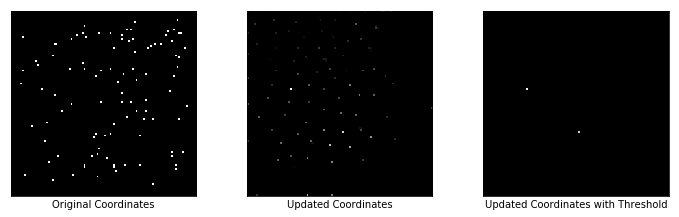

Epochs: 800, Session: 3
Reconstruction Loss: 0.0007397394510917366
Regularizer Loss: 18546.720703125, Total Loss: 18546.720703125
Encoder Loss: 0.02244039997458458
Max Similarity scores: 0.3895362913608551
Updated Coordinates: [[[0.5005502 0.       ]]]
Gradient global min:-0.0014177807606756687, max:0.002768393838778138
Gradient encoder min:-0.015746014192700386, max:0.012220353819429874
Gradient learnable coords min:-5.71046257391572e-05, max:1.6741929357522167e-05



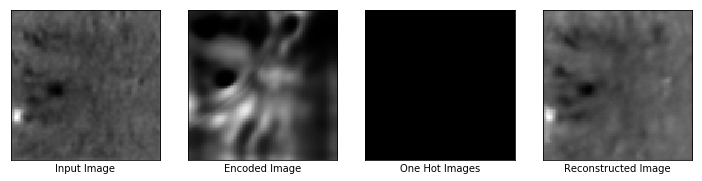

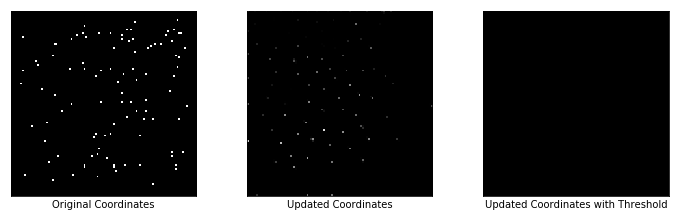

Epochs: 800, Session: 4
Reconstruction Loss: 0.0008534346707165241
Regularizer Loss: 18404.03125, Total Loss: 18404.03125
Encoder Loss: 0.011707617901265621
Max Similarity scores: 0.21043868362903595
Updated Coordinates: [[[0.5048462 0.       ]]]
Gradient global min:-0.008145774714648724, max:0.007873929105699062
Gradient encoder min:-0.012061414308845997, max:0.00796862505376339
Gradient learnable coords min:-9.833401236392092e-06, max:9.699992915557232e-06



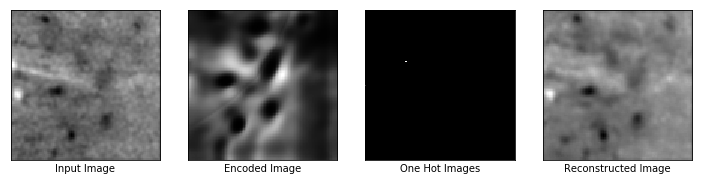

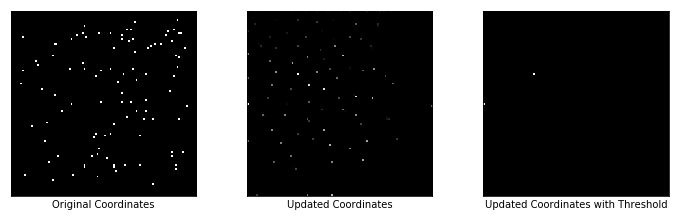

Epochs: 800, Session: 5
Reconstruction Loss: 0.0017583916196599603
Regularizer Loss: 19133.94921875, Total Loss: 19133.951171875
Encoder Loss: 0.027462778612971306
Max Similarity scores: 0.3289892375469208
Updated Coordinates: [[[0.50508404 0.        ]]]
Gradient global min:-0.004893784411251545, max:0.004591580480337143
Gradient encoder min:-0.015052367933094501, max:0.0154957864433527
Gradient learnable coords min:-2.9601389542222023e-05, max:7.37834197934717e-05



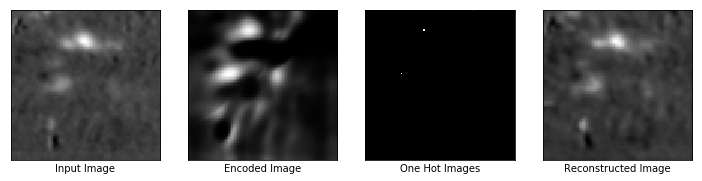

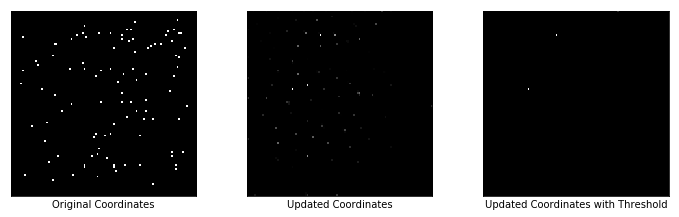

Epochs: 900, Session: 0
Reconstruction Loss: 0.0008849758305586874
Regularizer Loss: 21083.005859375, Total Loss: 21083.005859375
Encoder Loss: 0.016538064926862717
Max Similarity scores: 0.3493284285068512
Updated Coordinates: [[[0.47204626 0.        ]]]
Gradient global min:-0.0035297288559377193, max:0.004176392685621977
Gradient encoder min:-0.013031156733632088, max:0.010830058716237545
Gradient learnable coords min:-7.601627294206992e-05, max:1.7953327187569812e-05



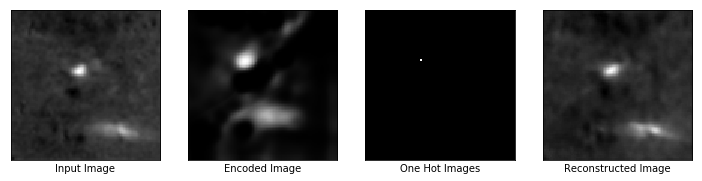

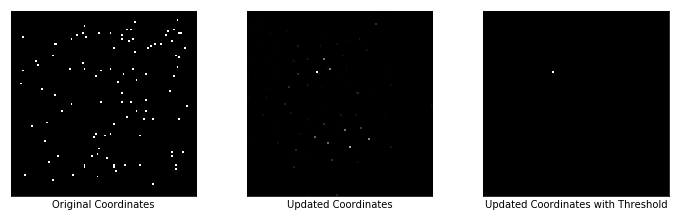

Epochs: 900, Session: 1
Reconstruction Loss: 0.0006351443007588387
Regularizer Loss: 21382.59765625, Total Loss: 21382.59765625
Encoder Loss: 0.0020841597579419613
Max Similarity scores: 0.4535435736179352
Updated Coordinates: [[[0.4724485 0.       ]]]
Gradient global min:-6.93963811499998e-05, max:0.00018754656775854528
Gradient encoder min:-0.0025386884808540344, max:0.0013805757043883204
Gradient learnable coords min:-1.359005273116054e-05, max:4.6093546188785695e-06



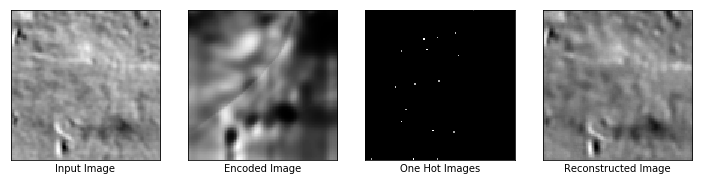

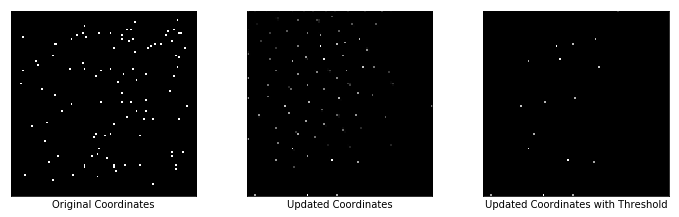

Epochs: 900, Session: 2
Reconstruction Loss: 0.001017646980471909
Regularizer Loss: 21518.103515625, Total Loss: 21518.10546875
Encoder Loss: 0.03923078626394272
Max Similarity scores: 0.46465399861335754
Updated Coordinates: [[[0.47217795 0.        ]]]
Gradient global min:-0.00020862642850261182, max:0.0003624623641371727
Gradient encoder min:-0.025414207950234413, max:0.025198256596922874
Gradient learnable coords min:-6.1723858379991725e-06, max:4.719273874798091e-06



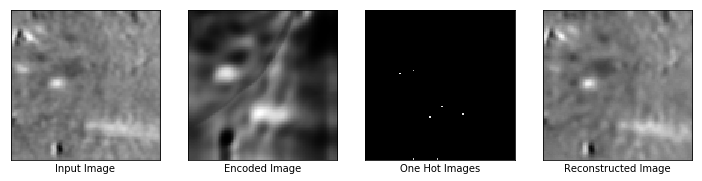

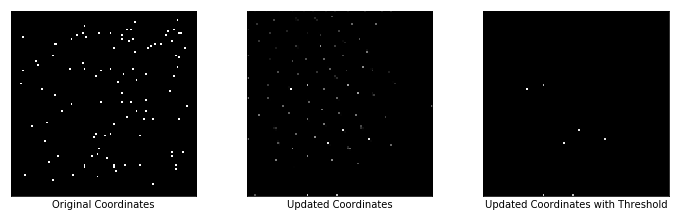

Epochs: 900, Session: 3
Reconstruction Loss: 0.0006311095203272998
Regularizer Loss: 20695.828125, Total Loss: 20695.828125
Encoder Loss: 0.02249840274453163
Max Similarity scores: 0.47789904475212097
Updated Coordinates: [[[0.47279212 0.        ]]]
Gradient global min:-0.02165704034268856, max:0.014906203374266624
Gradient encoder min:-0.01796816848218441, max:0.013752906583249569
Gradient learnable coords min:-6.535447482747259e-06, max:1.0010861842602026e-05



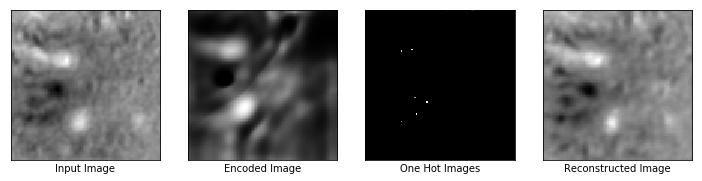

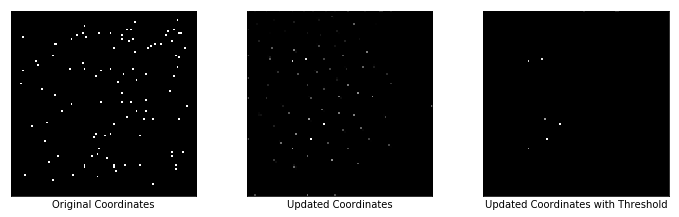

Epochs: 900, Session: 4
Reconstruction Loss: 0.0008815815672278404
Regularizer Loss: 20757.935546875, Total Loss: 20757.935546875
Encoder Loss: 0.011503071524202824
Max Similarity scores: 0.5256325006484985
Updated Coordinates: [[[0.4751095 0.       ]]]
Gradient global min:-0.0016328988131135702, max:0.0011581205762922764
Gradient encoder min:-0.011509843170642853, max:0.007791933137923479
Gradient learnable coords min:-3.762179767363705e-05, max:5.2375464292708784e-05



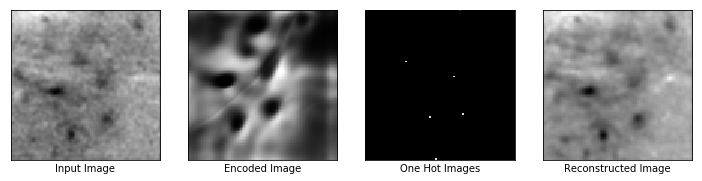

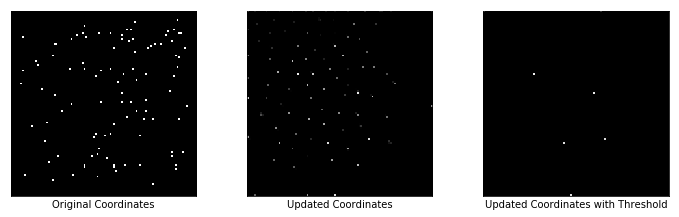

Epochs: 900, Session: 5
Reconstruction Loss: 0.001718641258776188
Regularizer Loss: 21163.34765625, Total Loss: 21163.349609375
Encoder Loss: 0.02968374639749527
Max Similarity scores: 0.39425426721572876
Updated Coordinates: [[[0.47517794 0.        ]]]
Gradient global min:-0.010236979462206364, max:0.022603867575526237
Gradient encoder min:-0.017336277291178703, max:0.018222663551568985
Gradient learnable coords min:-3.97339572373312e-05, max:2.880499050661456e-05



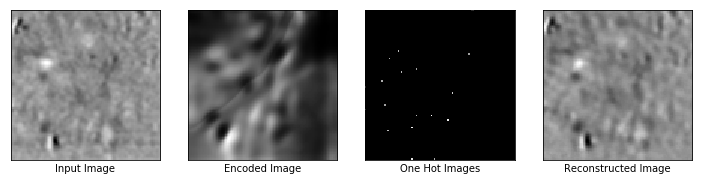

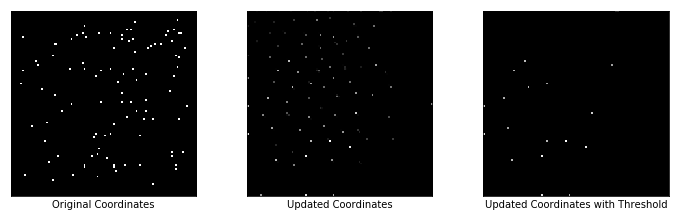

Epochs: 1000, Session: 0
Reconstruction Loss: 0.000830677046906203
Regularizer Loss: 23837.00390625, Total Loss: 23837.00390625
Encoder Loss: 0.01697787456214428
Max Similarity scores: 0.5378988981246948
Updated Coordinates: [[[0.4617673 0.       ]]]
Gradient global min:-0.01673368364572525, max:0.025476232171058655
Gradient encoder min:-0.012206921353936195, max:0.014222240075469017
Gradient learnable coords min:-1.8407792595098726e-05, max:1.7956235751626082e-05



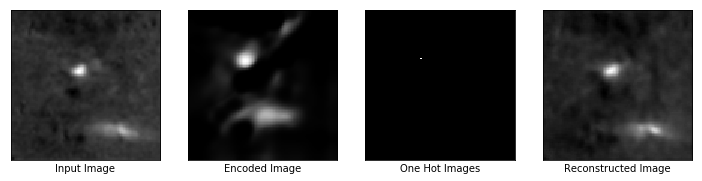

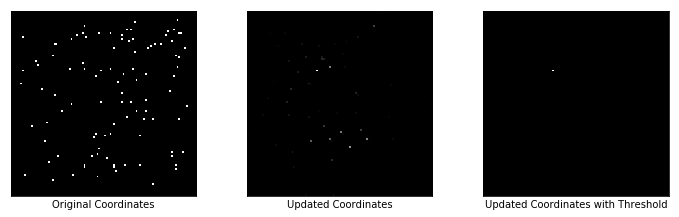

Epochs: 1000, Session: 1
Reconstruction Loss: 0.0007968217832967639
Regularizer Loss: 24481.5625, Total Loss: 24481.5625
Encoder Loss: 0.0016659690300002694
Max Similarity scores: 0.438053697347641
Updated Coordinates: [[[0.46166125 0.        ]]]
Gradient global min:-0.0002776556939352304, max:0.000491111190058291
Gradient encoder min:-0.0014249645173549652, max:0.0010906103998422623
Gradient learnable coords min:-9.008546840050258e-06, max:7.067529622872826e-06



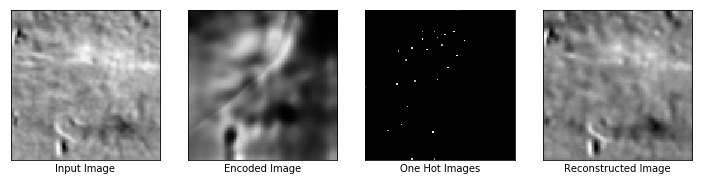

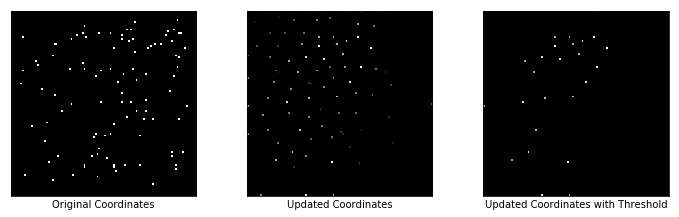

Epochs: 1000, Session: 2
Reconstruction Loss: 0.001908223726786673
Regularizer Loss: 24056.826171875, Total Loss: 24056.828125
Encoder Loss: 0.03848855197429657
Max Similarity scores: 0.4972020983695984
Updated Coordinates: [[[0.4618055 0.       ]]]
Gradient global min:-0.03031168319284916, max:0.06798633933067322
Gradient encoder min:-0.02635912597179413, max:0.032045986503362656
Gradient learnable coords min:-2.4064771423581988e-05, max:3.8606936868745834e-05



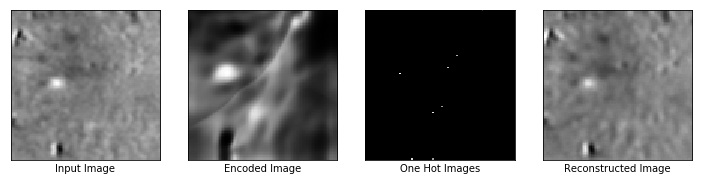

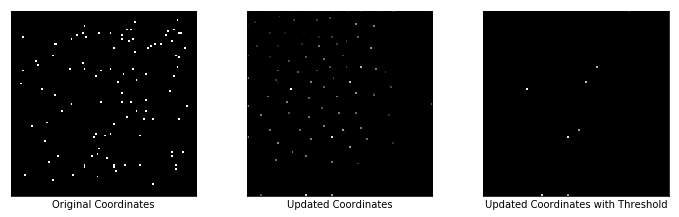

Epochs: 1000, Session: 3
Reconstruction Loss: 0.0006749048479832709
Regularizer Loss: 23295.66796875, Total Loss: 23295.66796875
Encoder Loss: 0.023405911400914192
Max Similarity scores: 0.5117157101631165
Updated Coordinates: [[[0.46227944 0.        ]]]
Gradient global min:-0.0003207119880244136, max:0.0004590685130096972
Gradient encoder min:-0.018925053998827934, max:0.018440574407577515
Gradient learnable coords min:-3.460142124822596e-06, max:5.721421985072084e-06



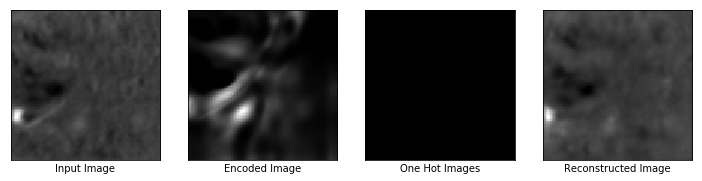

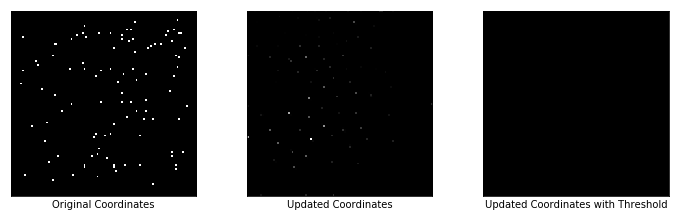

Epochs: 1000, Session: 4
Reconstruction Loss: 0.0009451049845665693
Regularizer Loss: 23523.5, Total Loss: 23523.5
Encoder Loss: 0.011455463245511055
Max Similarity scores: 0.27715736627578735
Updated Coordinates: [[[0.46265072 0.        ]]]
Gradient global min:-0.003430537413805723, max:0.006868167780339718
Gradient encoder min:-0.009810962714254856, max:0.00822305679321289
Gradient learnable coords min:-3.2121341064339504e-05, max:8.658149454277009e-06



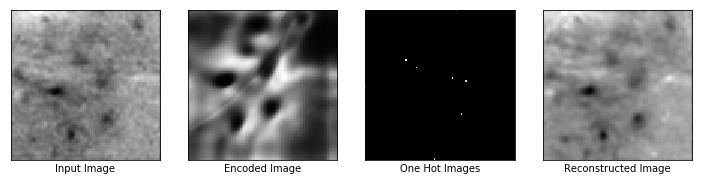

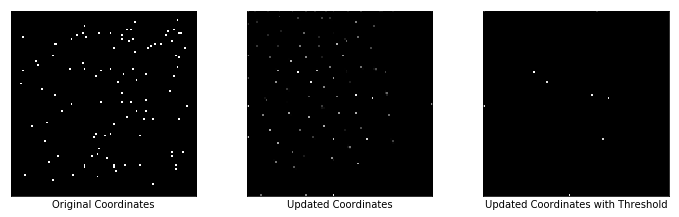

Epochs: 1000, Session: 5
Reconstruction Loss: 0.0019374351250007749
Regularizer Loss: 23636.935546875, Total Loss: 23636.9375
Encoder Loss: 0.030910883098840714
Max Similarity scores: 0.365249902009964
Updated Coordinates: [[[0.46252042 0.        ]]]
Gradient global min:-0.011764496564865112, max:0.02413218840956688
Gradient encoder min:-0.019264571368694305, max:0.025612838566303253
Gradient learnable coords min:-3.3668529795249924e-05, max:0.0001048026024363935


In [12]:
# batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
#list to be append to output 
loss_list_global = []
loss_list_encoded_one_hot = []
regulariser_loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates', 'Updated Coordinates with Threshold']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
#one epochs => loop through all sessions
while epochs <= MAX_EPOCHS:
    sess = 0
    #loops through all the sessions
    for session in sorted(os.listdir(ds_dir)):
        merge_sess = os.path.join(ds_dir+session)
        merge_sess = np.load(merge_sess)
        #resize the images
        re_list = utils.resize(merge_sess, NEW_SIZE)
        #add channel 
        re_list = np.expand_dims(re_list, axis = -1)
        re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
        batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)
        #initialize list to store data for sessions in last epochs
        one_hot_imgs_last_sess = []
        encoder_output_last_sess = []
        similarity_score_last_sess = []
        reconstruction_last_sess = []
        #loss for each session
        loss_sess = [] #reconstruction loss
        reg_loss_sess = [] #regularizer loss
        enc_loss_sess = [] #ecnoder loss
        for batched_imgs in batch_imgs:
            loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad = train_fn(batched_imgs, coords, 
                                                                                                                  IMG_SIZE, BATCH_SIZE,
                                                                                                                  neuron_multi = True,
                                                                                                                 one_hot_thr = True)
            #append all frames for final epochs per session!
            if epochs==MAX_EPOCHS:
                one_hot_imgs_last_sess.append(one_hot_imgs)
#                 encoder_output_last_sess.append(encoder_output)
                similarity_score_last_sess.append(similarity_score)
#                 reconstruction_last_sess.append(reconstruction)
        
        #append all sessions for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs_last_sess)
#             encoder_output_last_list.append(encoder_output_last_sess)
            similarity_score_last_list.append(similarity_score_last_sess)
#             reconstruction_last_list.append(reconstruction_last_sess)


        if epochs%100==0:
            rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
            img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand], reconstruction[rand]]
            img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(one_hot_imgs, similarity_score)[rand], similarity_multi(one_hot_imgs, similarity_score, thr=thr)[rand]]
            plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
            plot_comparison(img_row02, captions_02, n_col=len(img_row02), figsize = (10, 10))
            #print for each session in the epochs 
            #note for loss indices
            #loss = [global_loss, encoded_dummy, regularizer_loss, total_loss]
            print("Epochs: {}, Session: {}".format(epochs, sess))
            print("Reconstruction Loss: {}".format(loss[0].numpy()))
            print("Regularizer Loss: {}, Total Loss: {}".format(loss[2].numpy(), loss[-1].numpy()))
            print("Encoder Loss: {}".format(loss[1].numpy()))
            print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
            print("Updated Coordinates: {}".format(updated_coords[0]))
            print("Gradient global min:{}, max:{}".format(np.min(grad[0][rand]), np.max(grad[0][rand])))
            print("Gradient encoder min:{}, max:{}".format(np.min(grad[1][0]), np.max(grad[1][0])))
            print("Gradient learnable coords min:{}, max:{}".format(np.min(grad[2][0]), np.max(grad[2][0])))
            #append to list 
            encoded_imgs.append(encoder_output)
            input_imgs.append(batched_imgs)
            coords_list.append(updated_coords)
            reconstructed_imgs.append(reconstruction)
            one_hot_imgs_list.append(one_hot_imgs)
            similarity_list.append(similarity_score)
        
        sess+=1
        #append all losses for each session
        loss_sess.append(loss[0])
        reg_loss_sess.append(loss[1])
        enc_loss_sess.append(loss[-1])
    #loss is append for each epochs
    loss_list_global.append(np.mean(np.array(loss_sess)))
    loss_list_encoded_one_hot.append(np.mean(np.array(reg_loss_sess)))
    regulariser_loss_list.append(np.mean(np.array(enc_loss_sess)))
    #increment epochs
    epochs+=1

----

# Save Output Data

In [13]:
save_list = [loss_list_global, loss_list_encoded_one_hot, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list_global', 'loss_list_encoded_one_hot', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = '/home/kevinteng/Desktop/npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [14]:
#save coords and one hot images()
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [46]:
ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'
store_name = [d.split(".")[0] for d in sorted(os.listdir(ds_dir))]
#intended save path 
int_save_path = path_desktop+'npy/{}/sim_one_{}'.format(ver, ver)
#create new file to store sim score and one hot images for last frames
if not os.path.exists(int_save_path):
    os.makedirs(int_save_path)

#save sim scores for every session in last epochs 
similarity_score_last_list = utils.concat_batch(similarity_score_last_list) #(sess, frames, n_neurons)
for idx, stack in enumerate(similarity_score_last_list):
    np.save(int_save_path+'/sim_last_{}_{}.npy'.format(store_name[idx], ver), np.array(stack))

In [48]:
#save one hot imgs for last epochs 
for idx,stack in enumerate(one_hot_imgs_last_list):
    tensor = tf.convert_to_tensor(stack, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
    np.save(int_save_path+'/one_last_{}_{}.npy'.format(store_name[idx], ver), np.array(tensor))

In [38]:
# #save info for every frames in last epochs
# save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
# save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

# for names, items in zip(save_names_last, save_list_last):
#     aggregate_tensor = utils.concat_batch(items)
#     np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [47]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [ ]:
#save one hot imgs for last epochs 
# tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
# np.save(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [17]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [19]:
# coords list for every 100 epochs (max_epochs/100, n_neurons, 1, 1, 2)
coords_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
# encoder output first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
encoded_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
# input image first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
input_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
# global loss for every epochs
loss_list_global_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_global', ver))
#similarity loss for every epochs
loss_list_encoded_one_hot_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'loss_list_encoded_one_hot', ver))
# one hot images first batch for every 100 epochs  (max_epochs/100, n_neurons, 100, 100, 1)
one_hot_imgs_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
# reconstructed images first batch for every 100 epochs (max_epochs/100, 8, 100, 100, 1)
reconstructed_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
# similarity batch for every 100 epochs (max_epochs/100, 8, n_neurons)
similarity_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
#original coords list (n_neurons, 1, 1, 2)
ori_coords_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
#original one hot image (n_neurons, 100, 100, 1)
ori_one_hot_imgs_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [20]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

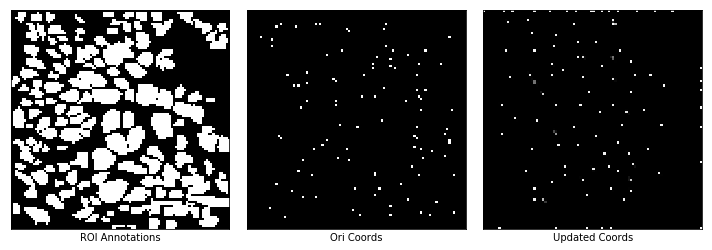

In [21]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.01
Counts:  108


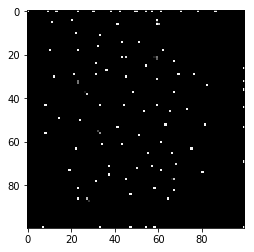

In [22]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.1, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

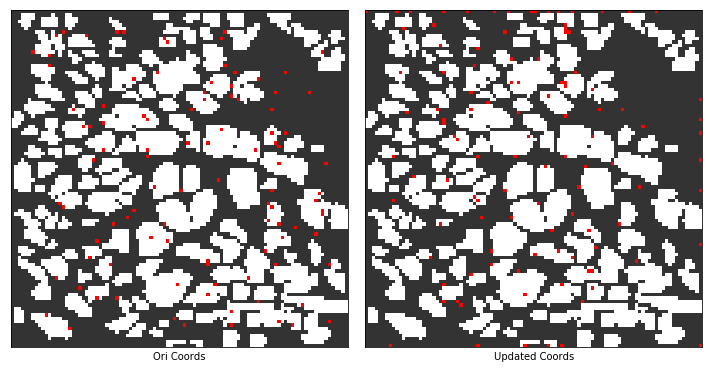

In [23]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks02(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm, norm = norm)

In [24]:
#confusion matrix 
confMatrix = utils_model.getConfusionMatrix(roi_img, updated_coords_img)

print("True Positives: ", confMatrix[0])
print("True Negatives: ", confMatrix[1])
print("False Positive Ratio: ", confMatrix[2])
print("False Negatives Ratio: ", confMatrix[3])
print("F1 score: ", utils_model.f1score(confMatrix))

True Positives:  0.0038
True Negatives:  0.007
False Positive Ratio:  0.4148
False Negatives Ratio:  0.5744
F1 score:  0.017699115044247787


---

# Similarity Scores with Threshold

In [25]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.7)

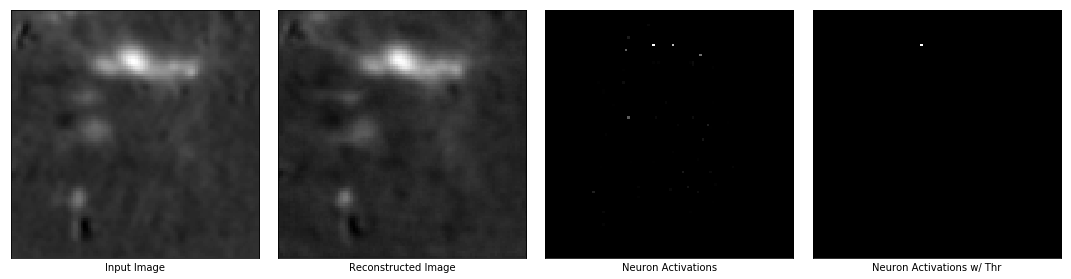

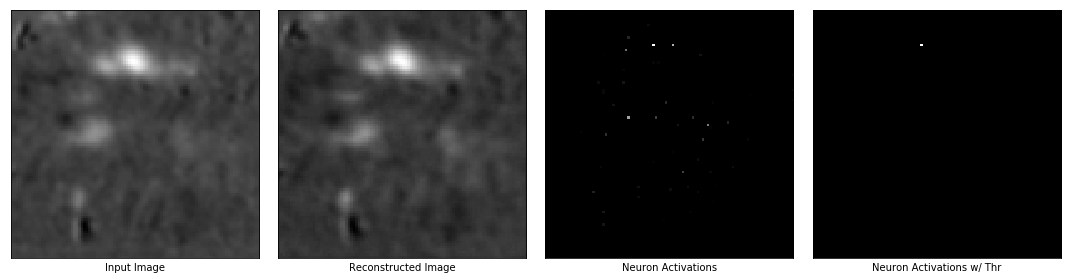

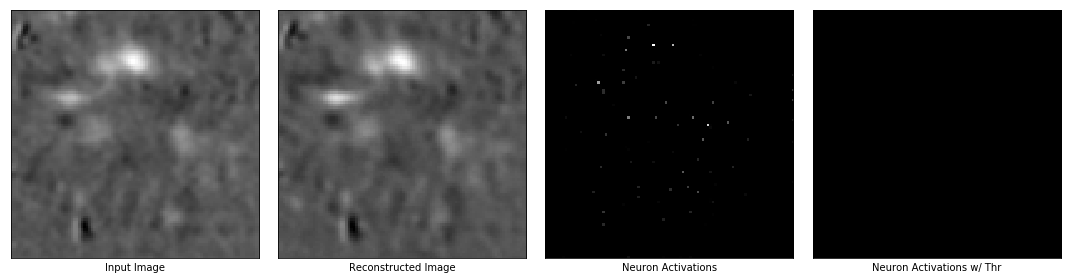

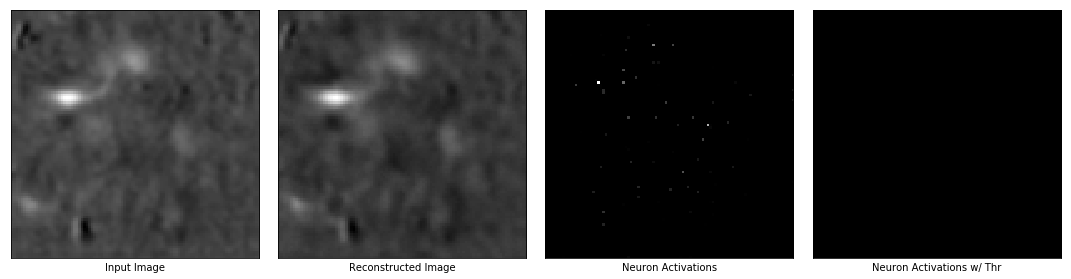

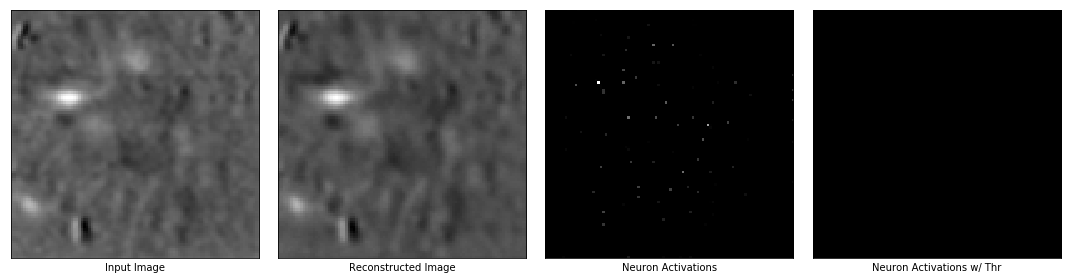

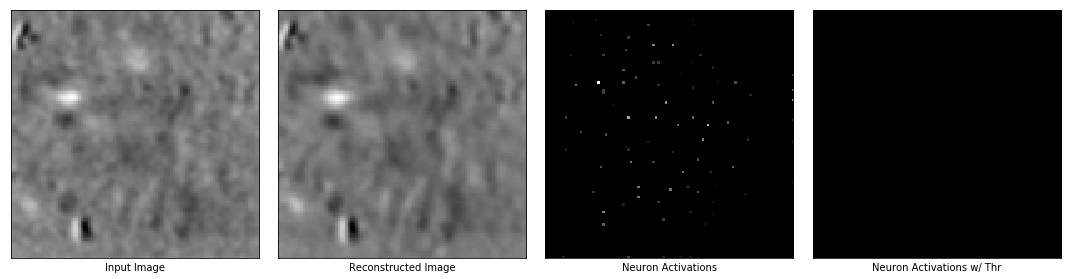

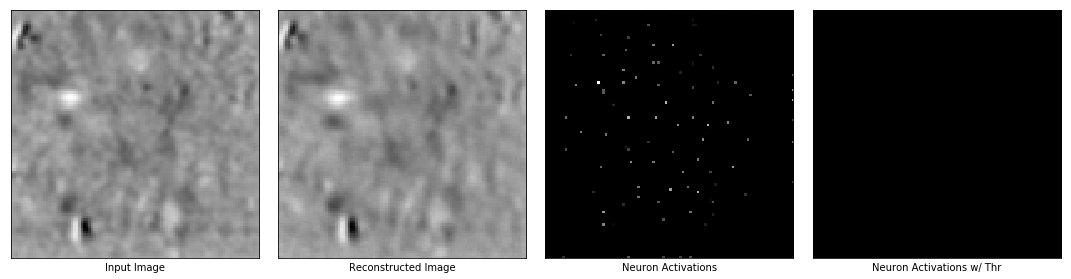

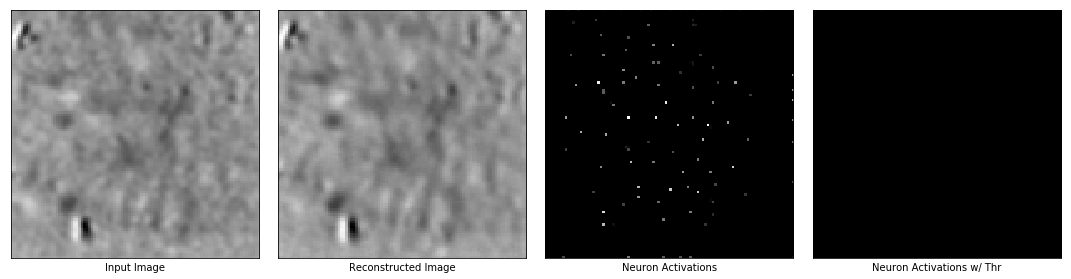

In [26]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

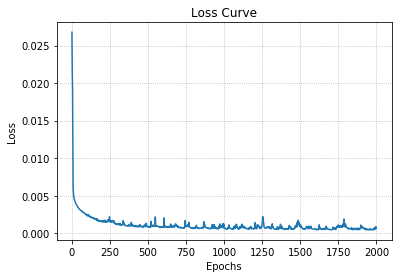

In [27]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_global_npy, xlabel, ylabel, title)

## Feature Maps

In [28]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))
encoder_model.load_weights("model_weights/encoder_model_{}.h5".format(ver))
#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))
decoder_model.load_weights("model_weights/decoder_model_{}.h5".format(ver))

#learnable coords
l_coords = learnable_coords(ori_coords_npy)

In [29]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_6
flatten_3
dense_1
reshape_1
up_sampling2d_6
coord_conv_7
activation_2
up_sampling2d_7
conv2d_32
activation_3
conv2d_33


In [30]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


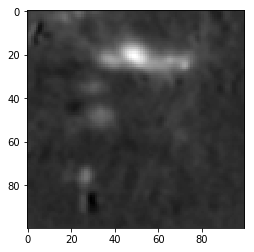

In [31]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


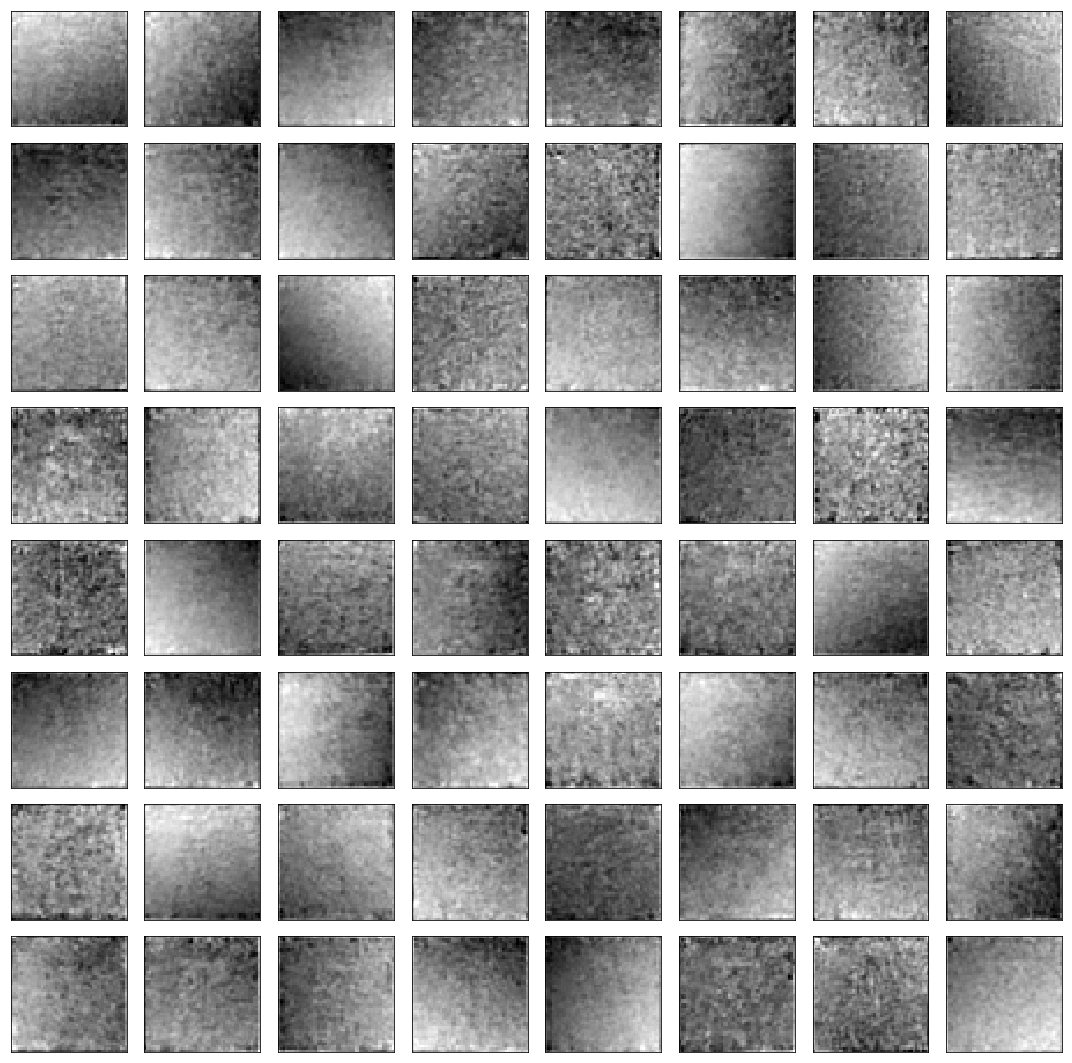

In [33]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


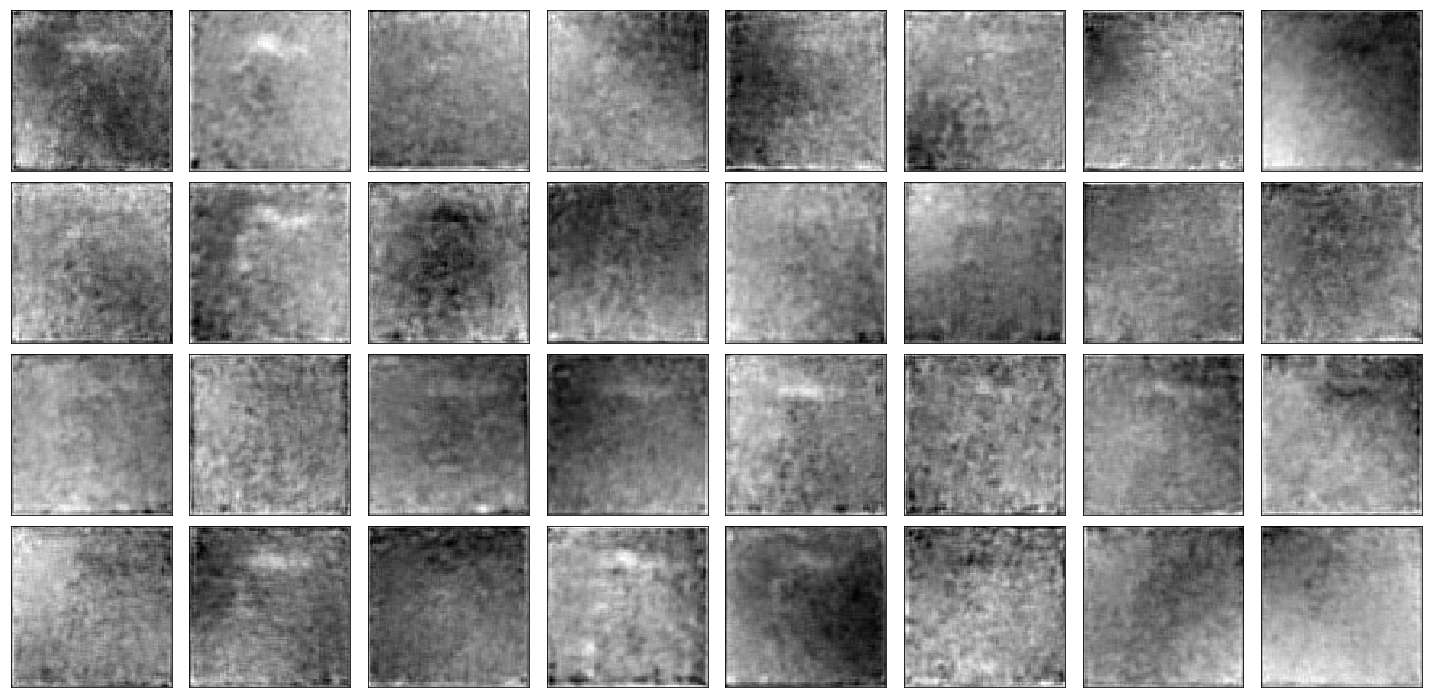

In [34]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

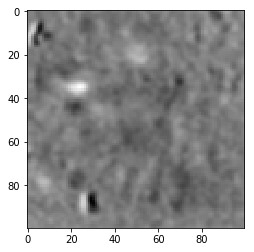

In [35]:
plt.imshow(np.squeeze(input_imgs_npy[-1,5]), cmap = 'gray')

In [36]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[5]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 100, 3, 1)


Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


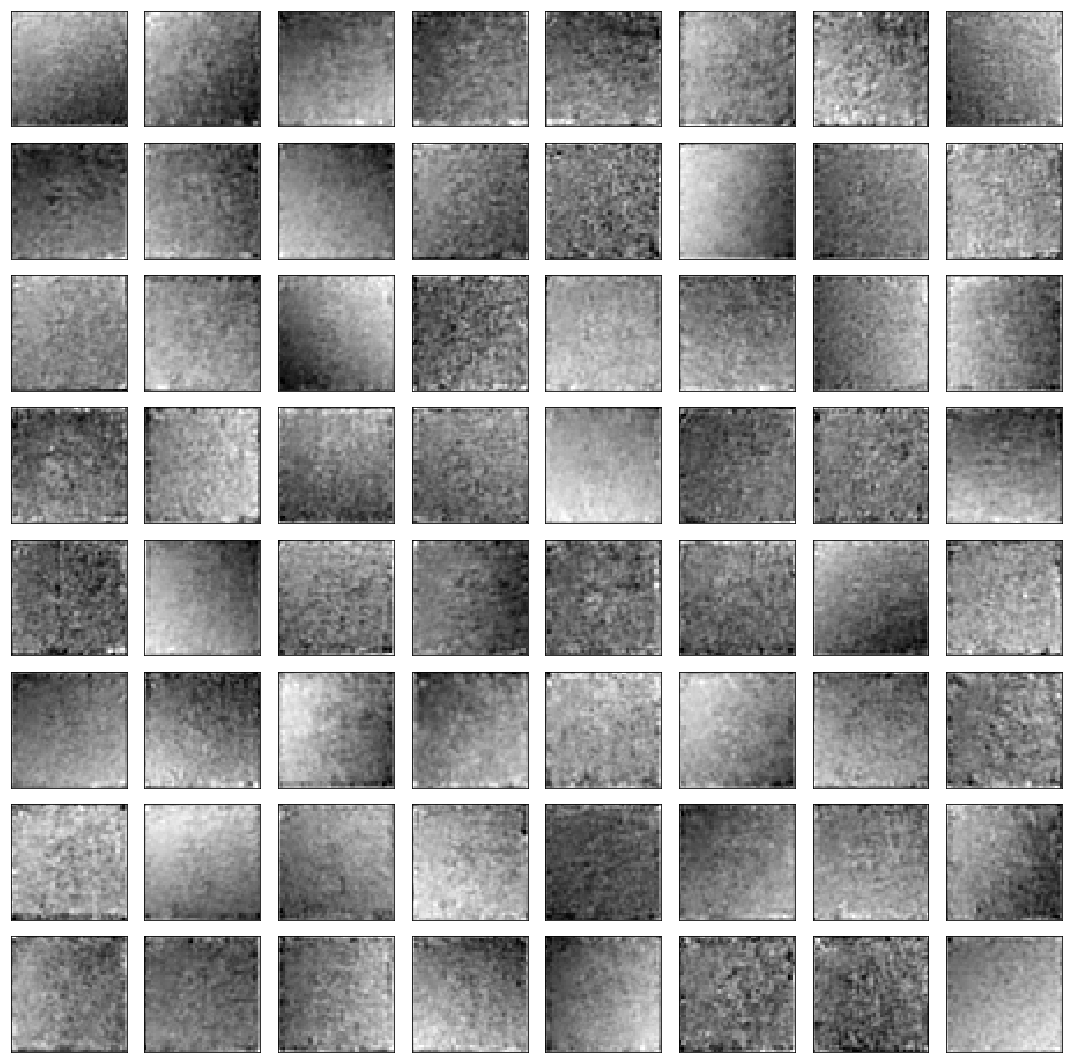

In [37]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_7', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


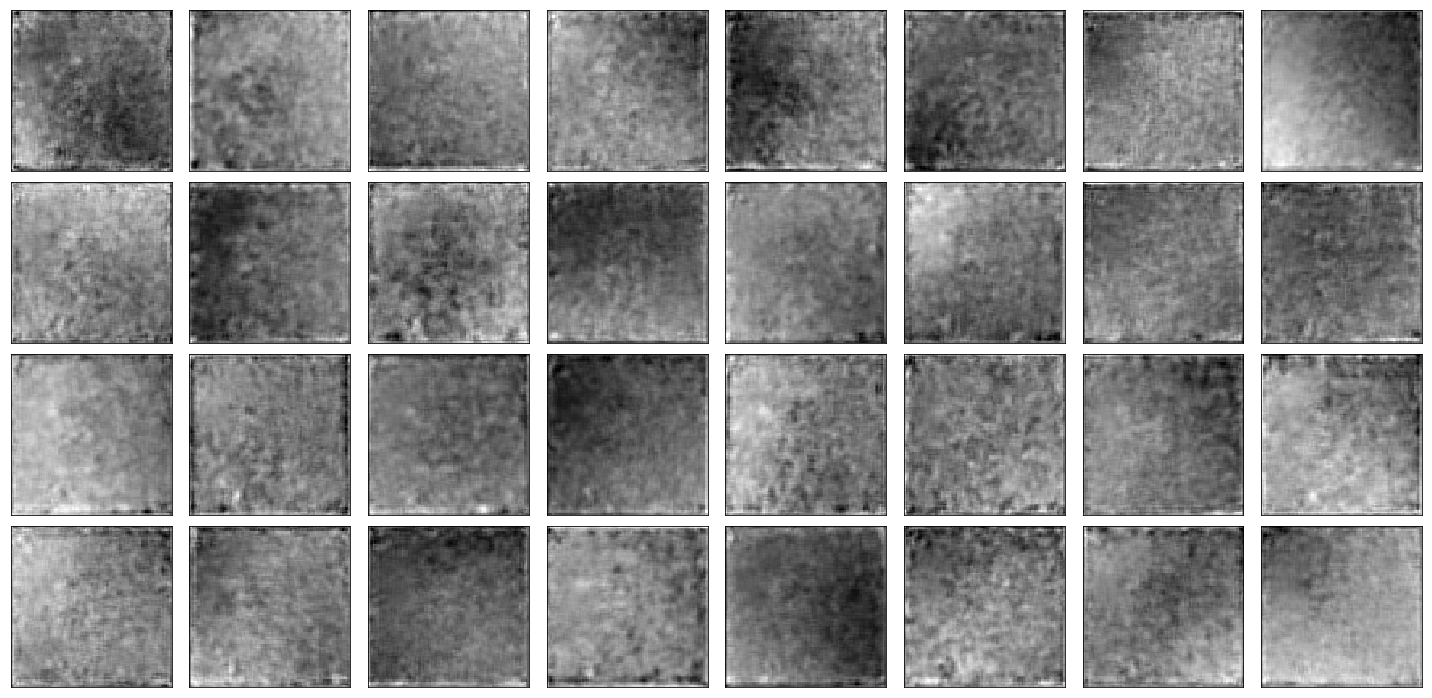

In [38]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_32', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [39]:
one_hot_imgs_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load(path_desktop+'npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [40]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [41]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [96]:
# plt_captions = ['Original Coordinates', 'Maximum Intensity Projection']
# plt_row = [stack4plot(ori_one_hot_imgs_npy), np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)]

# plot_comparison(plt_row , plt_captions, n_col=len(plt_row), figsize = (15, 15))

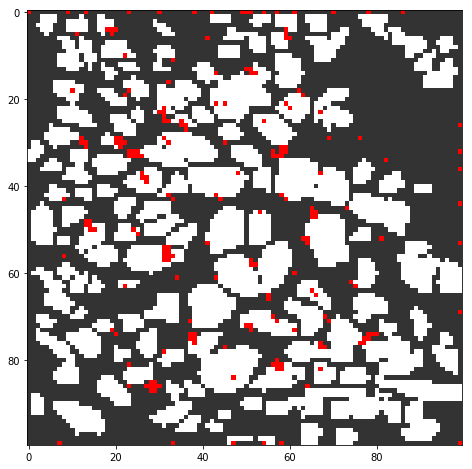

In [47]:
#define color
col = [(0.2, 0.2, 0.2),(1,1,1),(1,0,0)] 
cm = LinearSegmentedColormap.from_list('mylist', col, 3)  
#     #Bins for cmap
bounds=[0,1,5,10]
norm = BoundaryNorm(bounds, cm.N)

plt.figure(figsize=(8,8))
tensor_sum02 = np.where(np.sum(tensor, axis=0)<0.8, 0, 1.0)
roi_frame = overlapMasks02(roi_img, tensor_sum02)
plt.imshow(roi_frame, cmap = cm , norm = norm)
plt.show()

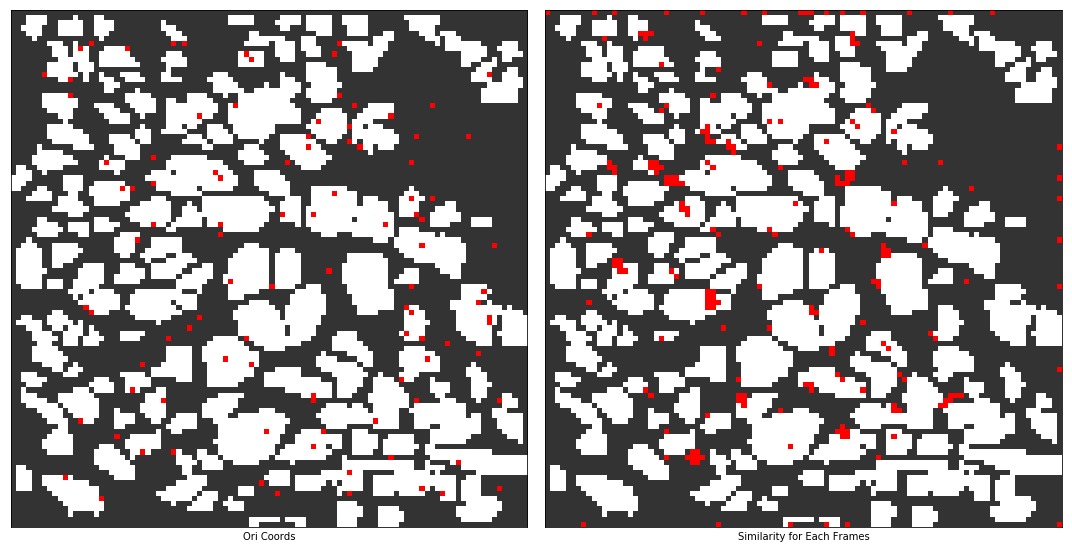

Counts:  201


In [43]:
#overlap mask with original coordinates 
roi_ori_mask = overlapMasks02(roi_img, stack4plot(ori_one_hot_imgs_npy))

captions_05 = ['Ori Coords', 'Similarity for Each Frames']
img_row05 = [roi_ori_mask, roi_frame]
plot_comparison(img_row05, captions_05, n_col=len(img_row05), figsize = (15, 15), cmap = cm, norm = norm)

activations_count = np.count_nonzero(tensor_sum02!=0)
print("Counts: ", activations_count)